##  <span style='background :#96e773' > 1. Introduction </span>

Ce notebook regroupe les scripts de preprocessing et de merging des différents jeux de données.
Les kernels Kaggle suivants ont été une source d'inspiration pour la réalisation des différents scripts :

[Kernel 1](https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script)
[Kernel 2](https://www.kaggle.com/code/hikmetsezen/base-model-with-0-804-auc-on-home-credit)
[Kernel 3](https://www.kaggle.com/code/ogrellier/lighgbm-with-selected-features)

In [1]:
# Importation des librairies

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import sys
import sklearn
import gc

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Versions
print('Version des librairies utilisées:')
print('Python ' + sys.version)
print('Pandas ' + pd.__version__)
print('NumPy ' + np.__version__)
print('Seaborn ' + sns.__version__)
print('Matplotlib ' + matplotlib.__version__)
print('Sklearn ' + sklearn.__version__)

Version des librairies utilisées:
Python 3.10.6 (tags/v3.10.6:9c7b4bd, Aug  1 2022, 21:53:49) [MSC v.1932 64 bit (AMD64)]
Pandas 1.5.2
NumPy 1.23.5
Seaborn 0.12.2
Matplotlib 3.5.3
Sklearn 1.2.2


In [2]:
from matplotlib import rcParams

# Définition des tailles de polices des figures


SMALL_SIZE = 15
MEDIUM_SIZE = 16
BIGGER_SIZE = 17

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('axes', titlesize=BIGGER_SIZE)

rcParams['axes.titlepad'] = 20
plt.rcParams['figure.dpi'] = 100

sns.set(style="darkgrid")

**Fonctions**

In [3]:
def dim(df):
    x, y = df.shape
    print(f'Le jeu de données contient {x} lignes et {y} colonnes.')

In [4]:
def missing_values(df):
    a = df.isna().sum().sum()
    b = round(df.isna().mean().mean() * 100, 3)
    print(f'Le jeu de données contient {a} valeurs manquantes ({b}%).')

In [5]:
def recap_missing_values(df):
    df = pd.DataFrame(df)
    a = df.notna().sum()
    b = df.isna().sum()
    c = round((1 - df.isna().mean()) * 100, 3)
    d = pd.concat([a, b, c], axis=1).reset_index()
    d.columns = ['Variable',
                 'Nombre de valeurs renseignées',
                 'Nombre de valeurs manquantes',
                 'Taux de remplissage (%)']
    return d

In [6]:
def pie(df, col, titre, explode=True):
    plt.title(titre)

    nbr = df[col].value_counts().sort_index()

    if explode:
        explode = [0.1]
        for i in range(len(nbr) - 1):
            explode.append(0)
    else:
        explode = [0]
        for i in range(len(nbr) - 1):
            explode.append(0)

    plt.pie(nbr, explode=explode, labels=nbr.index, autopct='%1.1f%%',
            textprops={'fontsize': 14, 'color': 'black', 'backgroundcolor': 'w'}, startangle=90)

    plt.axis('equal')
    plt.show()

In [7]:
def getDuplicateColumns(df):
    # Create an empty set
    duplicateColumnNames = set()

    # Iterate through all the columns
    # of dataframe
    for x in range(df.shape[1]):

        # Take column at xth index.
        col = df.iloc[:, x]

        # Iterate through all the columns in
        # DataFrame from (x + 1)th index to
        # last index
        for y in range(x + 1, df.shape[1]):

            # Take column at yth index.
            otherCol = df.iloc[:, y]

            # Check if two columns at x & y
            # index are equal or not,
            # if equal then adding
            # to the set
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])

    # Return list of unique column names
    # whose contents are duplicates.
    return list(duplicateColumnNames)

In [8]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [9]:
def detect_outliers(df, var, n, method='all', quantile_low=0.05, quantile_high=0.95, std_dev=3, iqr_factor=1.5):
    """
    Detects outliers in a pandas DataFrame using one or more methods.

    Parameters:
    - df: pandas DataFrame to be checked for outliers
    - n: minimum number of methods that must tag a data point as an outlier for it to be considered an outlier (default: 2)
    - method: one of 'all', 'percentile', 'std_dev', or 'iqr'; the outlier detection method to be used (default: 'all')
    - percentile_low: lower percentile value used in percentile method (default: 5)
    - percentile_high: upper percentile value used in percentile method (default: 95)
    - std_dev: number of standard deviations used in standard deviation method (default: 3)
    - iqr: number of interquartile ranges used in interquartile range method (default: 1.5)

    Returns:
    - outlier_df: pandas DataFrame with an additional column 'outlier' containing a boolean value indicating whether each data point is an outlier or not
    """
    outlier_count = np.zeros(len(df))

    if method in ('all', 'percentile'):
        q1 = df[var].quantile(quantile_low)
        q3 = df[var].quantile(quantile_high)
        is_outlier_percentile = (df[var] < q1) | (df[var] > q3)
        outlier_count += is_outlier_percentile

    if method in ('all', 'std_dev'):
        std = np.std(df[var], axis=0)
        mean = np.mean(df[var], axis=0)
        is_outlier_std_dev = np.abs(df[var] - mean) > std_dev * std
        outlier_count += is_outlier_std_dev

    if method in ('all', 'iqr'):
        q1 = df[var].quantile(0.25)
        q3 = df[var].quantile(0.75)
        iqr = q3 - q1
        is_outlier_iqr = (df[var] < q1 - iqr * iqr_factor) | (df[var] > q3 + iqr * iqr_factor)
        outlier_count += is_outlier_iqr

    outlier_df = df.copy()
    outlier_df['outlier_count'] = outlier_count

    return outlier_df[outlier_df['outlier_count']>=n].sort_values(by=var, ascending=False)

In [10]:
def percentile_report(df, columns):
    quantiles = [0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1]
    results = []
    for col in columns:
        col_results = []
        for q in quantiles:
            value = df[col].quantile(q)
            col_results.append(value)
        results.append(col_results)
    results_df = pd.DataFrame(results, columns=[f'{q*100}%' for q in quantiles], index=columns)
    return results_df

In [11]:
def compute_mode_percentage(df, columns, threshold, pr=True):
    data = []
    for col in columns:
        mode = df[col].mode().values[0]
        mode_perc = df[col].value_counts(normalize=True)[mode]

        data.append({'Column': col, 'Mode': mode, 'Mode_pct': mode_perc})

    result_df = pd.DataFrame(data)
    col = result_df.loc[result_df['Mode_pct'] >= threshold, 'Column'].tolist()

    if pr:
        print(result_df.sort_values(by='Mode_pct'))
        print('')

    print('Liste des features à supprimer :')
    print(col)
    return col

In [12]:
def comparaison_key(df1, df2, key1, key2):
    df1 = df1.dropna(subset=key1).drop_duplicates(subset=key1, keep='first')
    df2 = df2.dropna(subset=key2).drop_duplicates(subset=key2, keep='first')

    temp1 = df1[~df1[key1].isin(df2[key2])]

    if temp1.shape[0] == 0:
        print("Toutes les clés de df1 sont comprises dans df2")
    else:
        print(f'Nombre de clé de df1 absentes de df2 : {temp1.shape[0]}')
        return temp1

<br>

---

##  <span style='background :#96e773' > 2. Chargements des jeux de données </span>

On charge les jeux de données.

In [13]:
bureau = pd.read_csv("./data/bureau.csv")
b_bal = pd.read_csv("./data/bureau_balance.csv")
cc_bal = pd.read_csv("./data/credit_card_balance.csv")
ins_pay = pd.read_csv("./data/installments_payments.csv")
pos_bal = pd.read_csv("./data/POS_CASH_balance.csv")
pre_app = pd.read_csv("./data/previous_application.csv")

<br>

---

##  <span style='background :#96e773' > 3. application_train & application_test </span>

Nous allons reprendre les étapes de nettoyage et de feature engineering effectuées dans le notebook précédent et les condenser dans un script unique qui traitera à la fois le jeu d'entrainement et de test.

### <span style='background :#e3e33d' > 3.1 Script </span>

In [14]:
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [15]:
def get_age_label(days_birth):
    """ Return the age group label (int). """
    age_years = -days_birth / 365
    if age_years < 27: return 1
    elif age_years < 40: return 2
    elif age_years < 50: return 3
    elif age_years < 60: return 4
    elif age_years < 99: return 5
    else: return 0

In [16]:
# Fonction qui permet de déceler les features avec des valeurs infinies

def check_for_inf(df):

    # select only the numeric columns
    numeric_cols = df.select_dtypes(include=np.number).columns

    # Count number of inf values
    n_inf = np.isinf(df[numeric_cols]).sum().sum()

    print(f'Nombre de valeurs infinies: {n_inf}')

    if n_inf > 0:

        # check for inf in the numeric columns
        inf_cols = df[numeric_cols][np.isinf(df[numeric_cols])].any()

        # print the column names with inf values
        print('Liste de features avec inf:')
        print(inf_cols.index[inf_cols].tolist())

In [17]:
# Fonction qui permet de déceler les features avec 100 % de nan

def check_full_nan(df):

    nan_cols = df.columns[df.isna().all()].tolist()
    print('Liste de features full of nan:')
    print(nan_cols)

    df.drop(columns=nan_cols, inplace=True)

    return df

In [18]:
def application_train_test():

    # Read data and merge
    df = pd.read_csv("./data/application_train.csv")
    df_test = pd.read_csv("./data/application_test.csv")
    print("Train samples: {}, test samples: {}".format(len(df), len(df_test)))

    df = df.append(df_test).reset_index(drop=True)
    print(f'Taille après fusion : {df.shape}')

    del df_test
    gc.collect()

    col_doc = [f for f in df.columns if f.startswith('FLAG_DOC')]
    df['CNT_DOC'] = df[col_doc].sum(axis=1)

    df['PERC_INC_CRED'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['PERC_INC_ANN'] = df['AMT_INCOME_TOTAL'] / df['AMT_ANNUITY']

    # Remplacement des outliers extremes de revenus par np.nan
    df.loc[(df['AMT_INCOME_TOTAL'] > 1e7) & (df['PERC_INC_CRED'] > 20), ['AMT_INCOME_TOTAL', 'PERC_INC_CRED']] = np.nan

    df['AMT_MONTHS'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['PERC_INSURANCE_CRED'] = (df['AMT_CREDIT'] - df['AMT_GOODS_PRICE']) / df['AMT_CREDIT']
    df['INCOME_PER_MEMBER'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['INCOME_PER_CHILD'] = df['AMT_INCOME_TOTAL'] / (df['CNT_CHILDREN'] + 1)

    df.loc[df['DAYS_EMPLOYED'] == 0, 'DAYS_EMPLOYED'] = -1
    df.loc[df['NAME_INCOME_TYPE'] == 'Pensioner', 'DAYS_EMPLOYED'] = 40 * 365
    df.loc[df['NAME_INCOME_TYPE'] == 'Unemployed', 'DAYS_EMPLOYED'] = 20 * 7

    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['ID_TO_BIRTH_RATIO'] = df['DAYS_ID_PUBLISH'] / df['DAYS_BIRTH']
    df['CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / (df['DAYS_BIRTH'] / -365)
    df['INCOME_TO_BIRTH_RATIO'] = - df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH']
    df['PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
    df['AGE_END'] = df['AMT_MONTHS'] / 12 + (df['DAYS_BIRTH'] / -365)

    df['CAR_TO_EMPLOYED_RATIO'] = df['OWN_CAR_AGE'] / (df['DAYS_EMPLOYED'] / -365)
    df['INCOME_TO_EMPLOYED_RATIO'] = - df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']

    df['AGE_RANGE'] = df['DAYS_BIRTH'].apply(lambda x: get_age_label(x))

    df['EXT_SOURCE_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    df['EXT_SOURCE_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']

    df['EXT_SOURCE_1_TO_BIRTH_RATIO'] = df['EXT_SOURCE_1'] / (df['DAYS_BIRTH'] / -365)
    df['EXT_SOURCE_1_TO_EMPLOY_RATIO'] = df['EXT_SOURCE_1'] / (df['DAYS_EMPLOYED'] / -365)
    df['EXT_SOURCE_1*DAYS_BIRTH'] = df['EXT_SOURCE_1'] * (df['DAYS_BIRTH'] / -365)
    df['EXT_SOURCE_1*DAYS_EMPLOYED'] = df['EXT_SOURCE_1'] * (df['DAYS_EMPLOYED'] / -365)

    df['EXT_SOURCE_2_TO_BIRTH_RATIO'] = df['EXT_SOURCE_2'] / (df['DAYS_BIRTH'] / -365)
    df['EXT_SOURCE_2_TO_EMPLOY_RATIO'] = df['EXT_SOURCE_2'] / (df['DAYS_EMPLOYED'] / -365)
    df['EXT_SOURCE_2*DAYS_BIRTH'] = df['EXT_SOURCE_2'] * (df['DAYS_BIRTH'] / -365)
    df['EXT_SOURCE_2*DAYS_EMPLOYED'] = df['EXT_SOURCE_2'] * (df['DAYS_EMPLOYED'] / -365)
    df['EXT_SOURCE_2_TO_REGION_RATIO'] = df['EXT_SOURCE_2'] / df['REGION_RATING_CLIENT']
    df['EXT_SOURCE_2*REGION_RATING_CLIENT'] = df['EXT_SOURCE_2'] * df['REGION_RATING_CLIENT']

    df['EXT_SOURCE_3_TO_BIRTH_RATIO'] = df['EXT_SOURCE_3'] / (df['DAYS_BIRTH'] / -365)
    df['EXT_SOURCE_3*DAYS_BIRTH'] = df['EXT_SOURCE_3'] * (df['DAYS_BIRTH'] / -365)

    df['EXT_SOURCE_1_TO_EXT_SOURCE_2_RATIO'] = df['EXT_SOURCE_1'] / df['EXT_SOURCE_2']
    df['EXT_SOURCE_2_TO_EXT_SOURCE_3_RATIO'] = df['EXT_SOURCE_2'] / df['EXT_SOURCE_3']
    df['EXT_SOURCE_1_TO_EXT_SOURCE_3_RATIO'] = df['EXT_SOURCE_1'] / df['EXT_SOURCE_3']

    df['EXT_SOURCE_1*EXT_SOURCE_2'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2']
    df['EXT_SOURCE_2*EXT_SOURCE_3'] = df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['EXT_SOURCE_1*EXT_SOURCE_3'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_3']


    # After the feature engineering, check for inf
    check_for_inf(df)

    df.loc[df['AMT_REQ_CREDIT_BUREAU_QRT'] > 30, 'AMT_REQ_CREDIT_BUREAU_QRT'] = 30

    # # Remplacement des outliers extremes par np.nan
    df.loc[df['OBS_30_CNT_SOCIAL_CIRCLE'] > 100, 'OBS_30_CNT_SOCIAL_CIRCLE'] = np.nan


    # Remove the feature where mode % > 0.94
    col_to_del = compute_mode_percentage(df, df.columns, threshold=0.94, pr=False)
    df.drop(columns=col_to_del, inplace=True)


    # Remove the feature about client's residence
    cols_buildings = [i for i in df.columns if ('_MODE' in i) | ('_AVG' in i) | ('_MEDI' in i)]
    df.drop(columns=cols_buildings, inplace=True)


    # Cleaning of the categorical variables
    df.loc[df['CODE_GENDER'] == 'XNA', 'CODE_GENDER'] = 'F'
    df = df[df['NAME_INCOME_TYPE'] != 'Maternity leave']
    df = df[df['NAME_FAMILY_STATUS'] != 'Unknown']
    df.loc[df['NAME_INCOME_TYPE'] == 'Pensioner', 'OCCUPATION_TYPE'] = 'Pensioner'
    df.loc[df['NAME_INCOME_TYPE'] == 'Unemployed', 'OCCUPATION_TYPE'] = 'Unemployed'
    df.loc[df['NAME_INCOME_TYPE'] == 'Pensioner', 'ORGANIZATION_TYPE'] = 'Pensioner'
    df.loc[df['NAME_INCOME_TYPE'] == 'Unemployed', 'ORGANIZATION_TYPE'] = 'Unemployed'

    print(f'Taille après filtrage des catégories : {df.shape}')

    # Encoding of the categorical variables
    bin_features = [col for col in df.columns if df[col].dtype == 'object' and df[col].nunique() == 2]
    for b in bin_features:
        df[b], uniques = pd.factorize(df[b])

    df, cat_cols = one_hot_encoder(df, nan_as_category=True)

    check_full_nan(df)

    # Remove the feature where mode % = 1
    col_to_del = compute_mode_percentage(df, df.columns, threshold=1, pr=False)
    df.drop(columns=col_to_del, inplace=True)

    print('"Application_Train_Test" final shape:', df.shape)

    return df

In [19]:
temp_app = application_train_test()

Train samples: 307511, test samples: 48744
Taille après fusion : (356255, 122)
Nombre de valeurs infinies: 0
Liste des features à supprimer :
['FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'HOUSETYPE_MODE', 'EMERGENCYSTATE_MODE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK']
Taille après filtrage des catégories : (356248, 86)
Liste de features full of nan:
[]
Liste des features à supprimer :
['NAME_INCOME_TYPE_nan', 'NAME_EDUCATION_TYPE_nan', 'NAME_FAMILY_STATUS_nan', 'NAME_HOUSING_TYPE_nan', 'WEEKDAY_APPR_PROCESS_START_nan', 'ORGANIZATI

In [20]:
temp_app.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_Unemployed,ORGANIZATION_TYPE_University
0,100002,1.0,0,0,0,0,0,202500.0,406597.5,24700.5,...,0,0,0,0,0,0,0,0,0,0
1,100003,0.0,0,1,0,1,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0,0,0,0,0,0
2,100004,0.0,1,0,1,0,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0,0,0,0,0
3,100006,0.0,0,1,0,0,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0,0,0,0,0
4,100007,0.0,0,0,0,0,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0,0,0,0,0


In [21]:
dim(temp_app)

Le jeu de données contient 356248 lignes et 196 colonnes.


<br>

---

**Pour chacun des jeux de données additionnels, on effectuera l'analyse suivante :**

1) Étude des valeurs manquantes
2) Recherche de doublons
3) Comparaison des clients ID avec le jeu de données application_train
4) Étude des modalités des variables catégorielles
5) Calcul du pourcentage du mode de chaque variable et filtre si nécessaire
6) Analyse des centiles pour détecter d'éventuels outliers

##  <span style='background :#96e773' > 4. bureau & bureau_balance </span>
### <span style='background :#e3e33d' > 4.1 Analyses rapides </span>
#### <span style='background :#cdcdfc' > Bureau </span>

In [22]:
bureau = reduce_mem_usage(bureau)
bureau.head(10)

Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 119.49 MB
Decreased by 46.3%


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,9.132300e+04,0.000000,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,2.250000e+05,171342.000000,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,4.643235e+05,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,9.000000e+04,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2.700000e+06,NaN,NaN,0.0,Consumer credit,-21,NaN
5,215354,5714467,Active,currency 1,-273,0,27460.0,NaN,0.0,0,1.800000e+05,71017.382812,108982.617188,0.0,Credit card,-31,NaN
6,215354,5714468,Active,currency 1,-43,0,79.0,NaN,0.0,0,4.210380e+04,42103.800781,0.000000,0.0,Consumer credit,-22,NaN
7,162297,5714469,Closed,currency 1,-1896,0,-1684.0,-1710.0,14985.0,0,7.687845e+04,0.000000,0.000000,0.0,Consumer credit,-1710,NaN
8,162297,5714470,Closed,currency 1,-1146,0,-811.0,-840.0,0.0,0,1.030077e+05,0.000000,0.000000,0.0,Consumer credit,-840,NaN
9,162297,5714471,Active,currency 1,-1146,0,-484.0,NaN,0.0,0,4.500000e+03,0.000000,0.000000,0.0,Credit card,-690,NaN


In [23]:
dim(bureau)
missing_values(bureau)

Le jeu de données contient 1716428 lignes et 17 colonnes.
Le jeu de données contient 3939947 valeurs manquantes (13.503%).


In [24]:
bureau.dtypes.value_counts()

float32    8
int32      3
object     3
int16      2
int8       1
dtype: int64

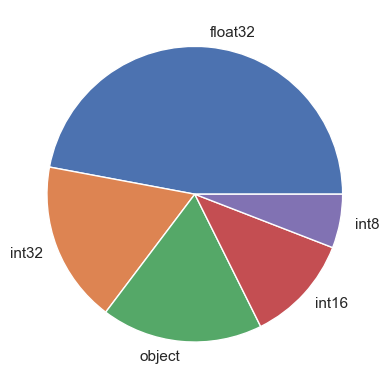

In [25]:
bureau.dtypes.value_counts().plot.pie()
plt.ylabel('')
plt.show()

In [26]:
recap_missing_values(bureau)

,Variable,Nombre de valeurs renseignées,Nombre de valeurs manquantes,Taux de remplissage (%)
0,SK_ID_CURR,1716428,0,100.000
1,SK_ID_BUREAU,1716428,0,100.000
2,CREDIT_ACTIVE,1716428,0,100.000
3,CREDIT_CURRENCY,1716428,0,100.000
4,DAYS_CREDIT,1716428,0,100.000
5,CREDIT_DAY_OVERDUE,1716428,0,100.000
6,DAYS_CREDIT_ENDDATE,1610875,105553,93.850
7,DAYS_ENDDATE_FACT,1082775,633653,63.083
8,AMT_CREDIT_MAX_OVERDUE,591940,1124488,34.487
9,CNT_CREDIT_PROLONG,1716428,0,100.000


In [27]:
# Recherche de colonnes doublons

duplicateColNames = getDuplicateColumns(bureau)
d = len(duplicateColNames)
print(f'Nombre de colonnes doublons : {d}')

Nombre de colonnes doublons : 0


In [28]:
# Recherche de lignes doublons sur chaque variable

d = bureau.duplicated(keep='first').sum()
print(f'Nombre de lignes doublons : {d}')

Nombre de lignes doublons : 0


In [29]:
bureau['SK_ID_CURR'].nunique()

305811

In [30]:
comparaison_key(temp_app, bureau, 'SK_ID_CURR', 'SK_ID_CURR').head(5)

Nombre de clé de df1 absentes de df2 : 50439


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_Unemployed,ORGANIZATION_TYPE_University
3,100006,0.0,0,1,0,0,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0,0,0,0,0
9,100012,0.0,1,0,0,0,0,135000.0,405000.0,20250.0,...,0,0,0,0,0,0,0,0,0,0
14,100018,0.0,0,1,0,0,0,189000.0,773680.5,32778.0,...,0,0,0,0,0,1,0,0,0,0
17,100021,0.0,1,1,0,0,1,81000.0,270000.0,13500.0,...,0,0,0,0,0,0,0,0,0,0
20,100024,0.0,1,0,1,0,0,135000.0,427500.0,21375.0,...,0,0,0,0,0,0,0,0,0,0


50437 clients absents de bureau et donc sans historique de crédit.

In [31]:
bureau = bureau[bureau['SK_ID_CURR'].isin(temp_app['SK_ID_CURR'])]
dim(bureau)

Le jeu de données contient 1716426 lignes et 17 colonnes.


In [32]:
bureau['SK_ID_BUREAU'].nunique()

1716426

In [33]:
list_var_categ = bureau.select_dtypes('object').columns.tolist()
list_var_categ

['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']

In [34]:
# Number of unique classes in each object column
bureau[list_var_categ].nunique()

CREDIT_ACTIVE       4
CREDIT_CURRENCY     4
CREDIT_TYPE        15
dtype: int64

In [35]:
for f in list_var_categ:
        print(f'{f} : {bureau[f].unique()}')
        print('')

CREDIT_ACTIVE : ['Closed' 'Active' 'Sold' 'Bad debt']

CREDIT_CURRENCY : ['currency 1' 'currency 2' 'currency 4' 'currency 3']

CREDIT_TYPE : ['Consumer credit' 'Credit card' 'Mortgage' 'Car loan' 'Microloan'
 'Loan for working capital replenishment' 'Loan for business development'
 'Real estate loan' 'Unknown type of loan' 'Another type of loan'
 'Cash loan (non-earmarked)' 'Loan for the purchase of equipment'
 'Mobile operator loan' 'Interbank credit'
 'Loan for purchase of shares (margin lending)']



In [36]:
col_to_del = compute_mode_percentage(bureau, columns=bureau.columns, threshold=0.94, pr=True)

                    Column             Mode      Mode_pct
1             SK_ID_BUREAU          5000000  5.826059e-07
0               SK_ID_CURR           120860  6.758229e-05
6      DAYS_CREDIT_ENDDATE              0.0  5.481500e-04
7        DAYS_ENDDATE_FACT           -329.0  7.490021e-04
4              DAYS_CREDIT             -364  7.748659e-04
15      DAYS_CREDIT_UPDATE               -7  1.077996e-02
10          AMT_CREDIT_SUM              0.0  3.879136e-02
16             AMT_ANNUITY              0.0  5.247050e-01
2            CREDIT_ACTIVE           Closed  6.287903e-01
11     AMT_CREDIT_SUM_DEBT              0.0  6.967802e-01
14             CREDIT_TYPE  Consumer credit  7.291978e-01
8   AMT_CREDIT_MAX_OVERDUE              0.0  7.950988e-01
12    AMT_CREDIT_SUM_LIMIT              0.0  9.337516e-01
9       CNT_CREDIT_PROLONG                0  9.946901e-01
5       CREDIT_DAY_OVERDUE                0  9.975432e-01
13  AMT_CREDIT_SUM_OVERDUE              0.0  9.975775e-01
3          CRE

In [37]:
bureau = bureau.drop(columns=col_to_del)

In [38]:
percentile_report(bureau, bureau.select_dtypes(include='number').columns)

,0%,1.0%,5.0%,10.0%,25.0%,50.0%,75.0%,90.0%,95.0%,99.0%,100%
SK_ID_CURR,100001.000,103618.00,117919.00,135602.0,188866.25,278055.0,367425.75,420963.500,4.386320e+05,4.527440e+05,456255.0
SK_ID_BUREAU,5000000.000,5018307.25,5092405.25,5184874.5,5463953.25,5926302.5,6385679.75,6660629.500,6.751975e+06,6.825134e+06,6843457.0
DAYS_CREDIT,-2922.000,-2867.00,-2665.00,-2443.0,-1666.00,-987.0,-474.00,-215.000,-1.250000e+02,-3.800000e+01,0.0
DAYS_CREDIT_ENDDATE,-42060.000,-2571.00,-2262.00,-1922.0,-1138.00,-330.0,474.00,1334.000,2.623000e+03,3.102900e+04,31199.0
DAYS_ENDDATE_FACT,-42023.000,-2639.00,-2393.00,-2159.0,-1489.00,-897.0,-425.00,-178.000,-9.400000e+01,-2.400000e+01,0.0
AMT_CREDIT_MAX_OVERDUE,0.000,0.00,0.00,0.0,0.00,0.0,0.00,7594.875,1.422046e+04,4.198877e+04,115987184.0
AMT_CREDIT_SUM,0.000,0.00,11250.00,22500.0,51300.00,125518.5,315000.00,778762.375,1.350000e+06,3.700919e+06,585000000.0
AMT_CREDIT_SUM_DEBT,-4705600.500,0.00,0.00,0.0,0.00,0.0,40153.50,295456.500,6.289029e+05,2.259730e+06,170100000.0
AMT_CREDIT_SUM_LIMIT,-586406.125,0.00,0.00,0.0,0.00,0.0,0.00,0.000,5.736116e+03,1.996208e+05,4705600.5
DAYS_CREDIT_UPDATE,-41947.000,-2531.00,-2079.00,-1561.0,-908.00,-395.0,-33.00,-13.000,-8.000000e+00,-3.000000e+00,372.0


In [39]:
# Incohérences sur AMT_CREDIT_SUM

bureau[bureau['AMT_CREDIT_SUM'] == 0].shape[0]

66582

In [40]:
# Incohérences sur AMT_ANNUITY

bureau[bureau['AMT_ANNUITY'] == 0].shape[0]

256915

#### <span style='background :#cdcdfc' > bureau_balance </span>

In [41]:
b_bal = reduce_mem_usage(b_bal)

Memory usage of dataframe is 624.85 MB
Memory usage after optimization is: 338.46 MB
Decreased by 45.8%


In [42]:
b_bal.head(10)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
5,5715448,-5,C
6,5715448,-6,C
7,5715448,-7,C
8,5715448,-8,C
9,5715448,-9,0


In [43]:
dim(b_bal)
missing_values(b_bal)

Le jeu de données contient 27299925 lignes et 3 colonnes.
Le jeu de données contient 0 valeurs manquantes (0.0%).


In [44]:
recap_missing_values(b_bal)

,Variable,Nombre de valeurs renseignées,Nombre de valeurs manquantes,Taux de remplissage (%)
0,SK_ID_BUREAU,27299925,0,100.0
1,MONTHS_BALANCE,27299925,0,100.0
2,STATUS,27299925,0,100.0


In [45]:
# Recherche de lignes doublons sur chaque variable

d = b_bal.duplicated(keep='first').sum()
print(f'Nombre de lignes doublons : {d}')

Nombre de lignes doublons : 0


In [46]:
b_bal['SK_ID_BUREAU'].nunique()

817395

In [47]:
comparaison_key(bureau, b_bal, 'SK_ID_BUREAU', 'SK_ID_BUREAU').head()

Nombre de clé de df1 absentes de df2 : 942072


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,-497,-153.0,-153.0,NaN,91323.0,0.0,NaN,Consumer credit,-131,NaN
1,215354,5714463,Active,-208,1075.0,NaN,NaN,225000.0,171342.0,NaN,Credit card,-20,NaN
2,215354,5714464,Active,-203,528.0,NaN,NaN,464323.5,NaN,NaN,Consumer credit,-16,NaN
3,215354,5714465,Active,-203,NaN,NaN,NaN,90000.0,NaN,NaN,Credit card,-16,NaN
4,215354,5714466,Active,-629,1197.0,NaN,77674.5,2700000.0,NaN,NaN,Consumer credit,-21,NaN


942063 crédits sans historique

In [48]:
list_var_categ = b_bal.select_dtypes('object').columns.tolist()
list_var_categ

['STATUS']

In [49]:
# Number of unique classes in each object column
b_bal[list_var_categ].nunique()

STATUS    8
dtype: int64

In [50]:
for f in list_var_categ:
        print(f'{f} : {b_bal[f].unique()}')
        print('')

STATUS : ['C' '0' 'X' '1' '2' '3' '5' '4']



In [51]:
col_to_del = compute_mode_percentage(b_bal, columns=b_bal.columns, threshold=0.94)

           Column     Mode  Mode_pct
0    SK_ID_BUREAU  5001709  0.000004
1  MONTHS_BALANCE       -1  0.022806
2          STATUS        C  0.499891

Liste des features à supprimer :
[]


<br>

---

### <span style='background :#e3e33d' > 4.2 Script bureau_balance </span>

In [52]:
def flatten_multi_index(df, prefix):
    df.columns = pd.Index([prefix + e[0] + "_" + e[1].upper() for e in df.columns.tolist()])

    return df.reset_index()

In [53]:
b_bal.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [54]:
# Script aggregation bureau_balance

b_bal, b_bal_cat = one_hot_encoder(b_bal, False)

b_bal_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'mean', 'size']}
for col in b_bal_cat:
    b_bal_aggregations[col] = ['mean']

b_bal_agg = b_bal.groupby('SK_ID_BUREAU').agg(b_bal_aggregations)
b_bal_agg = flatten_multi_index(b_bal_agg, prefix='')

In [55]:
b_bal_agg.head()

,SK_ID_BUREAU,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_MEAN,MONTHS_BALANCE_SIZE,STATUS_0_MEAN,STATUS_1_MEAN,STATUS_2_MEAN,STATUS_3_MEAN,STATUS_4_MEAN,STATUS_5_MEAN,STATUS_C_MEAN,STATUS_X_MEAN
0,5001709,-96,0,-48.0,97,0.000000,0.0,0.0,0.0,0.0,0.0,0.886598,0.113402
1,5001710,-82,0,-41.0,83,0.060241,0.0,0.0,0.0,0.0,0.0,0.578313,0.361446
2,5001711,-3,0,-1.5,4,0.750000,0.0,0.0,0.0,0.0,0.0,0.000000,0.250000
3,5001712,-18,0,-9.0,19,0.526316,0.0,0.0,0.0,0.0,0.0,0.473684,0.000000
4,5001713,-21,0,-10.5,22,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000


<br>

---

### <span style='background :#e3e33d' > 4.3 Script bureau </span>

In [56]:
def bureau_script():

    bureau = pd.read_csv("./data/bureau.csv")

    col_to_del = ['CREDIT_CURRENCY', 'CREDIT_DAY_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM_OVERDUE']
    bureau.drop(columns=col_to_del, inplace=True)

    b_bal = pd.read_csv("./data/bureau_balance.csv")

    b_bal, b_bal_cat = one_hot_encoder(b_bal, False)
    b_bal_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'mean', 'size']}
    for col in b_bal_cat:
        b_bal_aggregations[col] = ['mean']
    b_bal_agg = b_bal.groupby('SK_ID_BUREAU').agg(b_bal_aggregations)
    b_bal_agg = flatten_multi_index(b_bal_agg, prefix='')

    del b_bal
    gc.collect()

    # Cleaning
    bureau.loc[:, ['AMT_CREDIT_SUM', 'AMT_ANNUITY']] = bureau[['AMT_CREDIT_SUM', 'AMT_ANNUITY']].replace(0, np.nan)

    # Feature engineering
    bureau['CREDIT_DURATION'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_CREDIT']
    bureau['ENDDATE_DIF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
    bureau['UPDATE_RATIO'] = (bureau['DAYS_CREDIT_UPDATE'] - bureau['DAYS_CREDIT']) / (bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_CREDIT'])
    bureau.loc[:, ['UPDATE_RATIO']] = bureau['UPDATE_RATIO'].replace(np.inf, 1)

    bureau['DEBT_CREDIT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
    bureau['DEBT_CREDIT_PERCENTAGE'] = bureau['AMT_CREDIT_SUM_DEBT'] / bureau['AMT_CREDIT_SUM']


    # After the feature engineering, check for inf
    check_for_inf(bureau)


    # Balance availability of previous credit
    bureau['PREVIOUS_BALANCE'] = bureau['SK_ID_BUREAU'].isin(b_bal_agg['SK_ID_BUREAU']).astype('int')

    bureau, bureau_cat = one_hot_encoder(bureau, False)
    bureau = bureau.merge(b_bal_agg, how='left', on='SK_ID_BUREAU')

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'SK_ID_BUREAU': ['size'],
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean', 'max'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean', 'sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
        'CREDIT_DURATION': ['min', 'max', 'mean'],
        'ENDDATE_DIF': ['min', 'max', 'mean'],
        'UPDATE_RATIO': ['min', 'max', 'mean'],
        'DEBT_CREDIT_DIFF': ['min', 'max', 'mean'],
        'DEBT_CREDIT_PERCENTAGE': ['min', 'max', 'mean'],
        'PREVIOUS_BALANCE': ['mean']
    }

    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in b_bal_cat: cat_aggregations[cat + "_MEAN"] = ['mean']

    # Aggregation
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg = flatten_multi_index(bureau_agg, prefix='BURO_')

    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg = flatten_multi_index(active_agg, prefix='ACTIVE_')
    bureau_agg = bureau_agg.merge(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()

    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg = flatten_multi_index(closed_agg, prefix='CLOSED_')
    bureau_agg = bureau_agg.merge(closed_agg, how='left', on='SK_ID_CURR')

    del bureau, closed, closed_agg
    gc.collect()

    check_full_nan(bureau_agg)

    # Remove the feature where mode % = 1
    col_to_del = compute_mode_percentage(bureau_agg, bureau_agg.columns, threshold=1, pr=False)
    bureau_agg.drop(columns=col_to_del, inplace=True)

    print('"Bureau/Bureau Balance" final shape:', bureau_agg.shape)

    return bureau_agg

In [57]:
temp_bureau = bureau_script()
temp_bureau.head()

Nombre de valeurs infinies: 0
Liste de features full of nan:
[]
Liste des features à supprimer :
[]
"Bureau/Bureau Balance" final shape: (305811, 154)


,SK_ID_CURR,BURO_SK_ID_BUREAU_SIZE,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,...,CLOSED_UPDATE_RATIO_MIN,CLOSED_UPDATE_RATIO_MAX,CLOSED_UPDATE_RATIO_MEAN,CLOSED_DEBT_CREDIT_DIFF_MIN,CLOSED_DEBT_CREDIT_DIFF_MAX,CLOSED_DEBT_CREDIT_DIFF_MEAN,CLOSED_DEBT_CREDIT_PERCENTAGE_MIN,CLOSED_DEBT_CREDIT_PERCENTAGE_MAX,CLOSED_DEBT_CREDIT_PERCENTAGE_MEAN,CLOSED_PREVIOUS_BALANCE_MEAN
0,100001,7,-1572,-49,-735.000000,240043.666667,-1329.0,1778.0,82.428571,-93.142857,...,1.032877,5.831276,2.692750,85500.0,279720.0,142335.0,0.0,0.0,0.0,1.0
1,100002,8,-1437,-103,-874.000000,186150.000000,-1072.0,780.0,-349.000000,-499.875000,...,0.257919,1.023810,0.761825,120735.0,135000.0,127867.5,0.0,0.0,0.0,1.0
2,100003,4,-2586,-606,-1400.750000,827783.583333,-2434.0,1216.0,-544.500000,-816.000000,...,0.633803,2.993421,1.542408,22248.0,112500.0,69133.5,0.0,0.0,0.0,0.0
3,100004,2,-1326,-408,-867.000000,421362.000000,-595.0,-382.0,-488.500000,-532.000000,...,0.880985,1.000000,0.940492,94500.0,94537.8,94518.9,0.0,0.0,0.0,0.0
4,100005,3,-373,-62,-190.666667,26340.333333,-128.0,1324.0,439.333333,-54.333333,...,1.028571,1.028571,1.028571,58500.0,58500.0,58500.0,0.0,0.0,0.0,1.0


In [58]:
dim(temp_bureau)

Le jeu de données contient 305811 lignes et 154 colonnes.


<br>

---

##  <span style='background :#96e773' > 5. previous_application </span>
### <span style='background :#e3e33d' > 5.1 Analyse rapide </span>

In [59]:
pre_app = reduce_mem_usage(pre_app)

Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 324.94 MB
Decreased by 31.1%


In [60]:
pre_app.head(10)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
5,1383531,199383,Cash loans,23703.929688,315000.0,340573.5,NaN,315000.0,SATURDAY,8,...,XNA,18.0,low_normal,Cash X-Sell: low,365243.0,-654.0,-144.0,-144.0,-137.0,1.0
6,2315218,175704,Cash loans,NaN,0.0,0.0,NaN,NaN,TUESDAY,11,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
7,1656711,296299,Cash loans,NaN,0.0,0.0,NaN,NaN,MONDAY,7,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
8,2367563,342292,Cash loans,NaN,0.0,0.0,NaN,NaN,MONDAY,15,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
9,2579447,334349,Cash loans,NaN,0.0,0.0,NaN,NaN,SATURDAY,15,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
dim(pre_app)
missing_values(pre_app)

Le jeu de données contient 1670214 lignes et 37 colonnes.
Le jeu de données contient 11109336 valeurs manquantes (17.977%).


In [62]:
pre_app.dtypes.value_counts()

object     16
float32    15
int32       3
int8        2
int16       1
dtype: int64

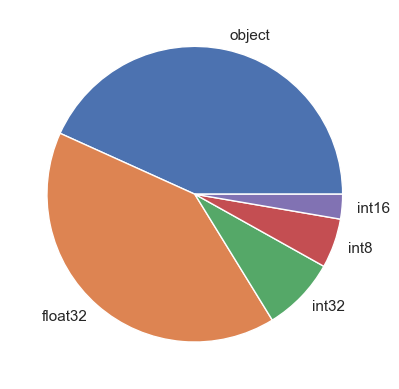

In [63]:
pre_app.dtypes.value_counts().plot.pie()
plt.ylabel('')
plt.show()

In [64]:
recap_missing_values(pre_app)

,Variable,Nombre de valeurs renseignées,Nombre de valeurs manquantes,Taux de remplissage (%)
0,SK_ID_PREV,1670214,0,100.000
1,SK_ID_CURR,1670214,0,100.000
2,NAME_CONTRACT_TYPE,1670214,0,100.000
3,AMT_ANNUITY,1297979,372235,77.713
4,AMT_APPLICATION,1670214,0,100.000
5,AMT_CREDIT,1670213,1,100.000
6,AMT_DOWN_PAYMENT,774370,895844,46.364
7,AMT_GOODS_PRICE,1284699,385515,76.918
8,WEEKDAY_APPR_PROCESS_START,1670214,0,100.000
9,HOUR_APPR_PROCESS_START,1670214,0,100.000


In [65]:
# Recherche de colonnes doublons

duplicateColNames = getDuplicateColumns(pre_app)
d = len(duplicateColNames)
print(f'Nombre de colonnes doublons : {d}')

Nombre de colonnes doublons : 0


In [66]:
# Recherche de lignes doublons sur chaque variable

d = pre_app.duplicated(keep='first').sum()
print(f'Nombre de lignes doublons : {d}')

Nombre de lignes doublons : 0


In [67]:
pre_app['SK_ID_CURR'].nunique()

338857

In [68]:
comparaison_key(temp_app, pre_app, 'SK_ID_CURR', 'SK_ID_CURR').head(5)

Nombre de clé de df1 absentes de df2 : 17393


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_Unemployed,ORGANIZATION_TYPE_University
20,100024,0.0,1,0,1,0,0,135000.0,427500.0,21375.0,...,0,0,0,0,0,0,0,0,0,0
26,100031,1.0,0,1,0,0,0,112500.0,979992.0,27076.5,...,0,0,0,0,0,0,0,0,0,0
50,100058,0.0,1,1,0,0,0,54000.0,135000.0,6750.0,...,0,0,0,0,0,0,0,0,0,0
64,100076,0.0,0,0,1,1,0,180000.0,315000.0,9679.5,...,0,0,0,0,0,0,1,0,0,0
81,100096,1.0,0,1,0,0,0,81000.0,252000.0,14593.5,...,0,0,0,0,0,0,0,0,0,0


17393 clients absents de previous_application, la demande de crédit actuelle est donc leur première demande.

In [69]:
pre_app = pre_app[pre_app['SK_ID_CURR'].isin(temp_app['SK_ID_CURR'])]
dim(pre_app)

Le jeu de données contient 1670198 lignes et 37 colonnes.


In [70]:
recap_missing_values(pre_app)

,Variable,Nombre de valeurs renseignées,Nombre de valeurs manquantes,Taux de remplissage (%)
0,SK_ID_PREV,1670198,0,100.000
1,SK_ID_CURR,1670198,0,100.000
2,NAME_CONTRACT_TYPE,1670198,0,100.000
3,AMT_ANNUITY,1297967,372231,77.713
4,AMT_APPLICATION,1670198,0,100.000
5,AMT_CREDIT,1670197,1,100.000
6,AMT_DOWN_PAYMENT,774364,895834,46.364
7,AMT_GOODS_PRICE,1284686,385512,76.918
8,WEEKDAY_APPR_PROCESS_START,1670198,0,100.000
9,HOUR_APPR_PROCESS_START,1670198,0,100.000


In [71]:
pre_app['SK_ID_PREV'].nunique()

1670198

In [72]:
list_var_categ = pre_app.select_dtypes('object').columns.tolist()
list_var_categ

['NAME_CONTRACT_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'NAME_CASH_LOAN_PURPOSE',
 'NAME_CONTRACT_STATUS',
 'NAME_PAYMENT_TYPE',
 'CODE_REJECT_REASON',
 'NAME_TYPE_SUITE',
 'NAME_CLIENT_TYPE',
 'NAME_GOODS_CATEGORY',
 'NAME_PORTFOLIO',
 'NAME_PRODUCT_TYPE',
 'CHANNEL_TYPE',
 'NAME_SELLER_INDUSTRY',
 'NAME_YIELD_GROUP',
 'PRODUCT_COMBINATION']

In [73]:
# Number of unique classes in each object column
pre_app[list_var_categ].nunique()

NAME_CONTRACT_TYPE              4
WEEKDAY_APPR_PROCESS_START      7
FLAG_LAST_APPL_PER_CONTRACT     2
NAME_CASH_LOAN_PURPOSE         25
NAME_CONTRACT_STATUS            4
NAME_PAYMENT_TYPE               4
CODE_REJECT_REASON              9
NAME_TYPE_SUITE                 7
NAME_CLIENT_TYPE                4
NAME_GOODS_CATEGORY            28
NAME_PORTFOLIO                  5
NAME_PRODUCT_TYPE               3
CHANNEL_TYPE                    8
NAME_SELLER_INDUSTRY           11
NAME_YIELD_GROUP                5
PRODUCT_COMBINATION            17
dtype: int64

In [74]:
for f in list_var_categ:
    if pre_app[f].nunique() < 10:
        print(f'{f} : {pre_app[f].unique()}')
        print('')

NAME_CONTRACT_TYPE : ['Consumer loans' 'Cash loans' 'Revolving loans' 'XNA']

WEEKDAY_APPR_PROCESS_START : ['SATURDAY' 'THURSDAY' 'TUESDAY' 'MONDAY' 'FRIDAY' 'SUNDAY' 'WEDNESDAY']

FLAG_LAST_APPL_PER_CONTRACT : ['Y' 'N']

NAME_CONTRACT_STATUS : ['Approved' 'Refused' 'Canceled' 'Unused offer']

NAME_PAYMENT_TYPE : ['Cash through the bank' 'XNA' 'Non-cash from your account'
 'Cashless from the account of the employer']

CODE_REJECT_REASON : ['XAP' 'HC' 'LIMIT' 'CLIENT' 'SCOFR' 'SCO' 'XNA' 'VERIF' 'SYSTEM']

NAME_TYPE_SUITE : [nan 'Unaccompanied' 'Spouse, partner' 'Family' 'Children' 'Other_B'
 'Other_A' 'Group of people']

NAME_CLIENT_TYPE : ['Repeater' 'New' 'Refreshed' 'XNA']

NAME_PORTFOLIO : ['POS' 'Cash' 'XNA' 'Cards' 'Cars']

NAME_PRODUCT_TYPE : ['XNA' 'x-sell' 'walk-in']

CHANNEL_TYPE : ['Country-wide' 'Contact center' 'Credit and cash offices' 'Stone'
 'Regional / Local' 'AP+ (Cash loan)' 'Channel of corporate sales'
 'Car dealer']

NAME_YIELD_GROUP : ['middle' 'low_action' 'high

In [75]:
for f in list_var_categ:
    if pre_app[f].nunique() > 10:
        print(f'{f} : {pre_app[f].unique()}')
        print('')

NAME_CASH_LOAN_PURPOSE : ['XAP' 'XNA' 'Repairs' 'Everyday expenses' 'Car repairs'
 'Building a house or an annex' 'Other' 'Journey'
 'Purchase of electronic equipment' 'Medicine' 'Payments on other loans'
 'Urgent needs' 'Buying a used car' 'Buying a new car'
 'Buying a holiday home / land' 'Education' 'Buying a home' 'Furniture'
 'Buying a garage' 'Business development' 'Wedding / gift / holiday'
 'Hobby' 'Gasification / water supply' 'Refusal to name the goal'
 'Money for a third person']

NAME_GOODS_CATEGORY : ['Mobile' 'XNA' 'Consumer Electronics' 'Construction Materials'
 'Auto Accessories' 'Photo / Cinema Equipment' 'Computers' 'Audio/Video'
 'Medicine' 'Clothing and Accessories' 'Furniture' 'Sport and Leisure'
 'Homewares' 'Gardening' 'Jewelry' 'Vehicles' 'Education'
 'Medical Supplies' 'Other' 'Direct Sales' 'Office Appliances' 'Fitness'
 'Tourism' 'Insurance' 'Additional Service' 'Weapon' 'Animals'
 'House Construction']

NAME_SELLER_INDUSTRY : ['Connectivity' 'XNA' 'Consumer 

"XNA" et "XAP" sont des valeurs manquantes.

In [76]:
marker_nan = ["XNA", "XAP"]
pre_app.replace(marker_nan, np.nan, inplace=True)

In [77]:
percentile_report(pre_app, [col for col in pre_app.columns if col.startswith('DAYS_')])

,0%,1.0%,5.0%,10.0%,25.0%,50.0%,75.0%,90.0%,95.0%,99.0%,100%
DAYS_DECISION,-2922.0,-2835.0,-2559.0,-2250.0,-1300.0,-581.0,-280.0,-152.0,-85.0,-14.0,-1.0
DAYS_FIRST_DRAWING,-2922.0,-2441.0,-269.0,365243.0,365243.0,365243.0,365243.0,365243.0,365243.0,365243.0,365243.0
DAYS_FIRST_DUE,-2892.0,-2822.0,-2608.0,-2392.0,-1628.0,-831.0,-411.0,-173.0,-48.0,365243.0,365243.0
DAYS_LAST_DUE_1ST_VERSION,-2801.0,-2599.0,-2327.0,-2047.0,-1242.0,-361.0,129.0,1432.0,365243.0,365243.0,365243.0
DAYS_LAST_DUE,-2889.0,-2618.0,-2349.0,-2081.0,-1314.0,-537.0,-74.0,365243.0,365243.0,365243.0,365243.0
DAYS_TERMINATION,-2874.0,-2589.0,-2331.0,-2052.0,-1270.0,-499.0,-44.0,365243.0,365243.0,365243.0,365243.0


In [78]:
pre_app['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
pre_app['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
pre_app['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
pre_app['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
pre_app['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

In [79]:
M = recap_missing_values(pre_app)
M

,Variable,Nombre de valeurs renseignées,Nombre de valeurs manquantes,Taux de remplissage (%)
0,SK_ID_PREV,1670198,0,100.000
1,SK_ID_CURR,1670198,0,100.000
2,NAME_CONTRACT_TYPE,1669852,346,99.979
3,AMT_ANNUITY,1297967,372231,77.713
4,AMT_APPLICATION,1670198,0,100.000
5,AMT_CREDIT,1670197,1,100.000
6,AMT_DOWN_PAYMENT,774364,895834,46.364
7,AMT_GOODS_PRICE,1284686,385512,76.918
8,WEEKDAY_APPR_PROCESS_START,1670198,0,100.000
9,HOUR_APPR_PROCESS_START,1670198,0,100.000


In [80]:
pre_app = pre_app[pre_app['AMT_CREDIT'].notna()]

In [81]:
col_to_del = M[M['Taux de remplissage (%)'] < 10]['Variable']
col_to_del.tolist()

['RATE_INTEREST_PRIMARY',
 'RATE_INTEREST_PRIVILEGED',
 'NAME_CASH_LOAN_PURPOSE',
 'DAYS_FIRST_DRAWING']

In [82]:
pre_app = pre_app.drop(columns=col_to_del)

In [83]:
col_to_del = compute_mode_percentage(pre_app, columns=pre_app.columns, threshold=0.94, pr=True)

                         Column                     Mode      Mode_pct
0                    SK_ID_PREV                  1000001  5.987318e-07
1                    SK_ID_CURR                   187868  4.610235e-05
29    DAYS_LAST_DUE_1ST_VERSION                      9.0  7.970986e-04
28               DAYS_FIRST_DUE                   -334.0  8.071135e-04
30                DAYS_LAST_DUE                   -245.0  8.372343e-04
31             DAYS_TERMINATION                   -233.0  1.019153e-03
14                DAYS_DECISION                     -245  1.463300e-03
3                   AMT_ANNUITY                   2250.0  2.454995e-02
7               AMT_GOODS_PRICE                  45000.0  3.723167e-02
9       HOUR_APPR_PROCESS_START                       11  1.153894e-01
8    WEEKDAY_APPR_PROCESS_START                  TUESDAY  1.527473e-01
27          PRODUCT_COMBINATION                     Cash  1.712656e-01
5                    AMT_CREDIT                      0.0  2.016325e-01
4     

In [84]:
pre_app = pre_app.drop(columns=col_to_del)

In [85]:
dim(pre_app)

Le jeu de données contient 1670197 lignes et 30 colonnes.


In [86]:
percentile_report(pre_app, pre_app.select_dtypes(include='number').columns)

,0%,1.0%,5.0%,10.0%,25.0%,50.0%,75.0%,90.0%,95.0%,99.0%,100%
SK_ID_PREV,1.000001e+06,1.018566e+06,1.092564e+06,1.185032e+06,1.461856e+06,1.923110e+06,2.384278e+06,2.660863e+06,2.753179e+06,2.826907e+06,2.845382e+06
SK_ID_CURR,1.000010e+05,1.034940e+05,1.179300e+05,1.357376e+05,1.893280e+05,2.787120e+05,3.675140e+05,4.213580e+05,4.384430e+05,4.527850e+05,4.562550e+05
AMT_ANNUITY,0.000000e+00,2.137185e+03,2.726606e+03,3.817530e+03,6.321780e+03,1.125000e+04,2.065842e+04,3.470382e+04,4.533678e+04,6.968616e+04,4.180582e+05
AMT_APPLICATION,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.872000e+04,7.104600e+04,1.803600e+05,4.500000e+05,7.875000e+05,1.350000e+06,6.905160e+06
AMT_CREDIT,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.416050e+04,8.053650e+04,2.164185e+05,5.331600e+05,8.865000e+05,1.515113e+06,6.905160e+06
AMT_DOWN_PAYMENT,-9.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.638000e+03,7.740000e+03,1.710900e+04,2.618235e+04,6.592666e+04,3.060045e+06
AMT_GOODS_PRICE,0.000000e+00,1.530000e+04,2.288250e+04,3.055500e+04,5.084100e+04,1.123200e+05,2.340000e+05,5.850000e+05,9.000000e+05,1.395000e+06,6.905160e+06
HOUR_APPR_PROCESS_START,0.000000e+00,5.000000e+00,7.000000e+00,8.000000e+00,1.000000e+01,1.200000e+01,1.500000e+01,1.700000e+01,1.800000e+01,2.000000e+01,2.300000e+01
RATE_DOWN_PAYMENT,-1.497876e-05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.160600e-02,1.089091e-01,2.119965e-01,2.941268e-01,5.210856e-01,1.000000e+00
DAYS_DECISION,-2.922000e+03,-2.835000e+03,-2.559000e+03,-2.250000e+03,-1.300000e+03,-5.810000e+02,-2.800000e+02,-1.520000e+02,-8.500000e+01,-1.400000e+01,-1.000000e+00


In [87]:
pre_app[pre_app['AMT_CREDIT'] == 0]['SK_ID_CURR'].nunique()

136260

<br>

---

### <span style='background :#e3e33d' > 5.2 Script </span>

In [88]:
def previous_application():

    pre_app = pd.read_csv("./data/previous_application.csv")

    # Cleaning
    col_to_del = ['RATE_INTEREST_PRIMARY',
                  'RATE_INTEREST_PRIVILEGED',
                  'NAME_CASH_LOAN_PURPOSE',
                  'DAYS_FIRST_DRAWING',
                  'FLAG_LAST_APPL_PER_CONTRACT',
                  'NFLAG_LAST_APPL_IN_DAY',
                  'NAME_PAYMENT_TYPE']

    pre_app.drop(columns=col_to_del, inplace=True)

    marker_nan = ["XNA", "XAP"]
    pre_app.replace(marker_nan, np.nan, inplace=True)

    pre_app['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    pre_app['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    pre_app['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    pre_app['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)

    pre_app = pre_app[pre_app['AMT_CREDIT'].notna()]

    col_min_zero = ['AMT_ANNUITY',
                    'AMT_APPLICATION',
                    'AMT_CREDIT',
                    'AMT_DOWN_PAYMENT',
                    'AMT_GOODS_PRICE']

    pre_app.loc[:, col_min_zero] = pre_app[col_min_zero].replace(0, np.nan)


    pre_app, cat_cols = one_hot_encoder(pre_app, nan_as_category=True)


    # Feature engineering
    pre_app['PREV_APP_CREDIT_PERC'] = pre_app['AMT_APPLICATION'] / pre_app['AMT_CREDIT']
    pre_app['PREV_APP_CREDIT_DIFF'] = pre_app['AMT_APPLICATION'] - pre_app['AMT_CREDIT']

    pre_app['PREV_AMT_MONTHS'] = pre_app['AMT_CREDIT'] / pre_app['AMT_ANNUITY']
    pre_app['PREV_PERC_INSURANCE_CRED'] = (pre_app['AMT_CREDIT'] - pre_app['AMT_GOODS_PRICE']) / pre_app['AMT_CREDIT']

    pre_app['PREV_DOWN_PAYMENT_TO_CREDIT'] = pre_app['AMT_DOWN_PAYMENT'] / pre_app['AMT_CREDIT']

    total_payment = pre_app['AMT_ANNUITY'] * pre_app['CNT_PAYMENT']
    pre_app['PREV_SIMPLE_INTERESTS'] = (total_payment / pre_app['AMT_CREDIT'] - 1) / (pre_app['CNT_PAYMENT'] + 0.1)

    pre_app['PREV_DAYS_LAST_DUE_DIFF'] = pre_app['DAYS_LAST_DUE_1ST_VERSION'] - pre_app['DAYS_LAST_DUE']

    pre_app['PREV_GOODS_DIFF'] = pre_app['AMT_APPLICATION'] - pre_app['AMT_GOODS_PRICE']
    pre_app['PREV_GOODS_RATIO'] = pre_app['AMT_APPLICATION'] / pre_app['AMT_GOODS_PRICE']


    # After the feature engineering, check for inf
    check_for_inf(pre_app)


    # Previous applications numeric features
    num_aggregations = {
        'SK_ID_PREV': ['nunique'],
        'AMT_ANNUITY': ['min', 'max', 'mean', 'sum'],
        'AMT_APPLICATION': ['min', 'max', 'mean', 'sum'],
        'AMT_CREDIT': ['min', 'max', 'mean', 'sum'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean', 'sum'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
        'DAYS_TERMINATION': ['max'],
        'PREV_APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'PREV_APP_CREDIT_DIFF': ['min', 'max', 'mean', 'sum'],
        'PREV_AMT_MONTHS': ['mean', 'max'],
        'PREV_PERC_INSURANCE_CRED': ['mean', 'max'],
        'PREV_DOWN_PAYMENT_TO_CREDIT': ['mean'],
        'PREV_SIMPLE_INTERESTS': ['mean', 'max'],
        'PREV_DAYS_LAST_DUE_DIFF': ['mean', 'max', 'sum'],
        'PREV_GOODS_DIFF': ['mean', 'max', 'sum'],
        'PREV_GOODS_RATIO': ['mean', 'max']
    }


    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']


    # Aggregation
    pre_app_agg = pre_app.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    pre_app_agg = flatten_multi_index(pre_app_agg, prefix='PREV_')


    # Previous Applications: Approved Applications - only numerical features
    approved = pre_app[pre_app['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg = flatten_multi_index(approved_agg, prefix='APPROVED_')
    pre_app_agg = pre_app_agg.merge(approved_agg, how='left', on='SK_ID_CURR')

    del approved, approved_agg
    gc.collect()

    # Previous Applications: Refused Applications - only numerical features
    refused = pre_app[pre_app['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg = flatten_multi_index(refused_agg, prefix='REFUSED_')
    pre_app_agg = pre_app_agg.merge(refused_agg, how='left', on='SK_ID_CURR')

    del pre_app, refused, refused_agg
    gc.collect()

    check_full_nan(pre_app_agg)

    # Remove the feature where mode % = 1
    col_to_del = compute_mode_percentage(pre_app_agg, pre_app_agg.columns, threshold=1, pr=False)
    pre_app_agg.drop(columns=col_to_del, inplace=True)

    print('"Previous Applications" final shape:', pre_app_agg.shape)

    return pre_app_agg

In [89]:
temp_previous = previous_application()
temp_previous.head()

Nombre de valeurs infinies: 0
Liste de features full of nan:
['REFUSED_DAYS_TERMINATION_MAX', 'REFUSED_PREV_DAYS_LAST_DUE_DIFF_MEAN', 'REFUSED_PREV_DAYS_LAST_DUE_DIFF_MAX']
Liste des features à supprimer :
['PREV_WEEKDAY_APPR_PROCESS_START_nan_MEAN', 'PREV_NAME_CONTRACT_STATUS_nan_MEAN', 'PREV_CHANNEL_TYPE_nan_MEAN', 'APPROVED_PREV_GOODS_DIFF_MEAN', 'APPROVED_PREV_GOODS_DIFF_MAX', 'APPROVED_PREV_GOODS_DIFF_SUM', 'APPROVED_PREV_GOODS_RATIO_MEAN', 'APPROVED_PREV_GOODS_RATIO_MAX', 'REFUSED_PREV_DAYS_LAST_DUE_DIFF_SUM']
"Previous Applications" final shape: (338857, 273)


,SK_ID_CURR,PREV_SK_ID_PREV_NUNIQUE,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_SUM,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_SUM,...,REFUSED_PREV_PERC_INSURANCE_CRED_MEAN,REFUSED_PREV_PERC_INSURANCE_CRED_MAX,REFUSED_PREV_DOWN_PAYMENT_TO_CREDIT_MEAN,REFUSED_PREV_SIMPLE_INTERESTS_MEAN,REFUSED_PREV_SIMPLE_INTERESTS_MAX,REFUSED_PREV_GOODS_DIFF_MEAN,REFUSED_PREV_GOODS_DIFF_MAX,REFUSED_PREV_GOODS_DIFF_SUM,REFUSED_PREV_GOODS_RATIO_MEAN,REFUSED_PREV_GOODS_RATIO_MAX
0,100001,1,3951.000,3951.000,3951.000,3951.000,24835.5,24835.5,24835.5,24835.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100002,1,9251.775,9251.775,9251.775,9251.775,179055.0,179055.0,179055.0,179055.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100003,3,6737.310,98356.995,56553.990,169661.970,68809.5,900000.0,435436.5,1306309.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100004,1,5357.250,5357.250,5357.250,5357.250,24282.0,24282.0,24282.0,24282.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100005,2,4813.200,4813.200,4813.200,4813.200,44617.5,44617.5,44617.5,44617.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
dim(temp_previous)

Le jeu de données contient 338857 lignes et 273 colonnes.


<br>

---

##  <span style='background :#96e773' > 6. POS_CASH_balance </span>
### <span style='background :#e3e33d' > 6.1 Analyse rapide </span>

In [91]:
pos_bal = reduce_mem_usage(pos_bal)

Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 276.60 MB
Decreased by 54.7%


In [92]:
pos_bal.head(10)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
5,2207092,342166,-32,12.0,12.0,Active,0,0
6,1110516,204376,-38,48.0,43.0,Active,0,0
7,1387235,153211,-35,36.0,36.0,Active,0,0
8,1220500,112740,-31,12.0,12.0,Active,0,0
9,2371489,274851,-32,24.0,16.0,Active,0,0


In [93]:
dim(pos_bal)
missing_values(pos_bal)

Le jeu de données contient 10001358 lignes et 8 colonnes.
Le jeu de données contient 52158 valeurs manquantes (0.065%).


In [94]:
pos_bal.dtypes.value_counts()

int32      2
float32    2
int16      2
int8       1
object     1
dtype: int64

In [95]:
# Recherche de lignes doublons sur chaque variable

d = pos_bal.duplicated(keep='first').sum()
print(f'Nombre de lignes doublons : {d}')

Nombre de lignes doublons : 0


In [96]:
pos_bal['SK_ID_CURR'].nunique()

337252

In [97]:
comparaison_key(temp_app, pos_bal, 'SK_ID_CURR', 'SK_ID_CURR').head(5)

Nombre de clé de df1 absentes de df2 : 18998


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_Unemployed,ORGANIZATION_TYPE_University
20,100024,0.0,1,0,1,0,0,135000.0,427500.0,21375.0,...,0,0,0,0,0,0,0,0,0,0
26,100031,1.0,0,1,0,0,0,112500.0,979992.0,27076.5,...,0,0,0,0,0,0,0,0,0,0
50,100058,0.0,1,1,0,0,0,54000.0,135000.0,6750.0,...,0,0,0,0,0,0,0,0,0,0
64,100076,0.0,0,0,1,1,0,180000.0,315000.0,9679.5,...,0,0,0,0,0,0,1,0,0,0
81,100096,1.0,0,1,0,0,0,81000.0,252000.0,14593.5,...,0,0,0,0,0,0,0,0,0,0


18998 clients absents de POS_CASH_balance et donc sans historique des précédents prêts.

In [98]:
pos_bal = pos_bal[pos_bal['SK_ID_CURR'].isin(temp_app['SK_ID_CURR'])]
dim(pos_bal)

Le jeu de données contient 10001227 lignes et 8 colonnes.


In [99]:
pos_bal['SK_ID_PREV'].nunique()

936316

In [100]:
list_var_categ = pos_bal.select_dtypes('object').columns.tolist()
list_var_categ

['NAME_CONTRACT_STATUS']

In [101]:
# Number of unique classes in each object column
pos_bal[list_var_categ].nunique()

NAME_CONTRACT_STATUS    9
dtype: int64

In [102]:
for f in list_var_categ:
        print(f'{f} : {pos_bal[f].unique()}')
        print('')

NAME_CONTRACT_STATUS : ['Active' 'Completed' 'Signed' 'Approved' 'Returned to the store' 'Demand'
 'Canceled' 'XNA' 'Amortized debt']



"XNA" sont des valeurs manquantes.

In [103]:
marker_nan = ["XNA"]
pos_bal.replace(marker_nan, np.nan, inplace=True)

In [104]:
M = recap_missing_values(pos_bal)
M

,Variable,Nombre de valeurs renseignées,Nombre de valeurs manquantes,Taux de remplissage (%)
0,SK_ID_PREV,10001227,0,100.000
1,SK_ID_CURR,10001227,0,100.000
2,MONTHS_BALANCE,10001227,0,100.000
3,CNT_INSTALMENT,9975156,26071,99.739
4,CNT_INSTALMENT_FUTURE,9975140,26087,99.739
5,NAME_CONTRACT_STATUS,10001225,2,100.000
6,SK_DPD,10001227,0,100.000
7,SK_DPD_DEF,10001227,0,100.000


In [105]:
pos_bal[pos_bal['NAME_CONTRACT_STATUS'].isna()]

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
1614508,1378042,142208,-21,NaN,NaN,NaN,0,0
1614509,1711630,309000,-24,NaN,NaN,NaN,0,0


In [106]:
pos_bal = pos_bal[pos_bal['NAME_CONTRACT_STATUS'].notna()]

<br>

---

### <span style='background :#e3e33d' > 6.2 Script </span>

In [107]:
def pos_cash():

    pos_bal = pd.read_csv("./data/POS_CASH_balance.csv")

    # Cleaning
    marker_nan = ["XNA"]
    pos_bal.replace(marker_nan, np.nan, inplace=True)
    pos_bal = pos_bal[pos_bal['NAME_CONTRACT_STATUS'].notna()]

    pos_bal, cat_cols = one_hot_encoder(pos_bal, nan_as_category=True)

    # Feature engineering
    pos_bal['POS_LATE_PAYMENT'] = pos_bal['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    pos_bal['POS_IS_DPD_OVER_120'] = pos_bal['SK_DPD'].apply(lambda x: 1 if x >= 120 else 0)
    pos_bal['POS_DPD_DEF_RATIO'] = pos_bal['SK_DPD_DEF'] / (pos_bal['SK_DPD'] + 1)


    # After the feature engineering, check for inf
    check_for_inf(pos_bal)


    # pos balance numeric features
    num_aggregations = {
        'SK_ID_PREV': ['nunique'],
        'SK_ID_CURR': ['size'],
        'MONTHS_BALANCE': ['max', 'mean'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean'],
        'POS_LATE_PAYMENT': ['mean'],
        'POS_IS_DPD_OVER_120': ['mean'],
        'POS_DPD_DEF_RATIO': ['max', 'mean']
    }

    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    # Aggregation
    pos_bal_agg = pos_bal.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    pos_bal_agg = flatten_multi_index(pos_bal_agg, prefix='POS_')

    # Sort and group by SK_ID_PREV
    sort_pos = pos_bal.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'])
    gp = sort_pos.groupby('SK_ID_PREV')

    df = pd.DataFrame()
    df['SK_ID_CURR'] = gp['SK_ID_CURR'].first()

    # Percentage of previous loans completed and completed before initial term
    df['POS_LOAN_COMPLETED_MEAN'] = gp['NAME_CONTRACT_STATUS_Completed'].mean()
    df['POS_COMPLETED_BEFORE_MEAN'] = gp['CNT_INSTALMENT'].first() - gp['CNT_INSTALMENT'].last()
    df['POS_COMPLETED_BEFORE_MEAN'] = df.apply(lambda x: 1 if x['POS_COMPLETED_BEFORE_MEAN'] > 0
                                                              and x['POS_LOAN_COMPLETED_MEAN'] > 0 else 0, axis=1)

    # Number of remaining installments (future installments) and percentage from total
    df['POS_REMAINING_INSTALMENTS'] = gp['CNT_INSTALMENT_FUTURE'].last()
    df['POS_REMAINING_INSTALMENTS_RATIO'] = gp['CNT_INSTALMENT_FUTURE'].last() / gp['CNT_INSTALMENT'].last()

    # Group by SK_ID_CURR and merge
    df_gp = df.groupby('SK_ID_CURR').sum().reset_index()

    pos_bal_agg = pd.merge(pos_bal_agg, df_gp, on='SK_ID_CURR', how='left')

    del sort_pos, gp, df, df_gp
    gc.collect()

    check_full_nan(pos_bal_agg)

    # Remove the feature where mode % = 1
    col_to_del = compute_mode_percentage(pos_bal_agg, pos_bal_agg.columns, threshold=1, pr=False)
    pos_bal_agg.drop(columns=col_to_del, inplace=True)

    print('"Pos-Cash" balance final shape:', pos_bal_agg.shape)

    return pos_bal_agg

In [108]:
temp_pos = pos_cash()
temp_pos.head()

Nombre de valeurs infinies: 0
Liste de features full of nan:
[]
Liste des features à supprimer :
['POS_NAME_CONTRACT_STATUS_nan_MEAN']
"Pos-Cash" balance final shape: (337252, 25)


,SK_ID_CURR,POS_SK_ID_PREV_NUNIQUE,POS_SK_ID_CURR_SIZE,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_POS_LATE_PAYMENT_MEAN,...,POS_NAME_CONTRACT_STATUS_Approved_MEAN,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN,POS_NAME_CONTRACT_STATUS_Signed_MEAN,POS_LOAN_COMPLETED_MEAN,POS_COMPLETED_BEFORE_MEAN,POS_REMAINING_INSTALMENTS,POS_REMAINING_INSTALMENTS_RATIO
0,100001,2,9,-53,-72.555556,7,0.777778,7,0.777778,0.111111,...,0.0,0.0,0.222222,0.0,0.0,0.000000,0.450000,0,0.0,0.000000
1,100002,1,19,-1,-10.000000,0,0.000000,0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0,6.0,0.250000
2,100003,3,28,-18,-43.785714,0,0.000000,0,0.000000,0.000000,...,0.0,0.0,0.071429,0.0,0.0,0.000000,0.250000,1,1.0,0.083333
3,100004,1,4,-24,-25.500000,0,0.000000,0,0.000000,0.000000,...,0.0,0.0,0.250000,0.0,0.0,0.000000,0.250000,1,0.0,0.000000
4,100005,1,11,-15,-20.000000,0,0.000000,0,0.000000,0.000000,...,0.0,0.0,0.090909,0.0,0.0,0.090909,0.090909,1,0.0,0.000000


In [109]:
dim(temp_pos)

Le jeu de données contient 337252 lignes et 25 colonnes.


<br>

---

##  <span style='background :#96e773' > 7. installments_payments </span>
### <span style='background :#e3e33d' > 7.1 Analyse rapide </span>

In [110]:
ins_pay = pd.read_csv("./data/installments_payments.csv")

In [111]:
ins_pay = reduce_mem_usage(ins_pay)

Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 389.25 MB
Decreased by 53.1%


In [112]:
ins_pay.head(10)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961
5,1137312,164489,1.0,12,-1384.0,-1417.0,5970.375000,5970.375000
6,2234264,184693,4.0,11,-349.0,-352.0,29432.294922,29432.294922
7,1818599,111420,2.0,4,-968.0,-994.0,17862.164062,17862.164062
8,2723183,112102,0.0,14,-197.0,-197.0,70.739998,70.739998
9,1413990,109741,1.0,4,-570.0,-609.0,14308.469727,14308.469727


In [113]:
dim(ins_pay)
missing_values(ins_pay)

Le jeu de données contient 13605401 lignes et 8 colonnes.
Le jeu de données contient 5810 valeurs manquantes (0.005%).


In [114]:
M = recap_missing_values(ins_pay)
M

,Variable,Nombre de valeurs renseignées,Nombre de valeurs manquantes,Taux de remplissage (%)
0,SK_ID_PREV,13605401,0,100.000
1,SK_ID_CURR,13605401,0,100.000
2,NUM_INSTALMENT_VERSION,13605401,0,100.000
3,NUM_INSTALMENT_NUMBER,13605401,0,100.000
4,DAYS_INSTALMENT,13605401,0,100.000
5,DAYS_ENTRY_PAYMENT,13602496,2905,99.979
6,AMT_INSTALMENT,13605401,0,100.000
7,AMT_PAYMENT,13602496,2905,99.979


In [115]:
ins_pay[ins_pay['DAYS_ENTRY_PAYMENT'].isna()].head(10)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
3764207,1531600,103793,1.0,7,-668.0,NaN,49741.019531,NaN
3764208,1947105,159974,1.0,24,-36.0,NaN,22849.515625,NaN
3764209,1843773,167270,1.0,22,-20.0,NaN,48092.355469,NaN
3764210,1691592,192536,1.0,5,-2561.0,NaN,7675.424805,NaN
3764211,1531299,157088,0.0,11,-1847.0,NaN,67.500000,NaN
3764212,1562727,187345,0.0,23,-5.0,NaN,11401.740234,NaN
3764213,1265332,167942,1.0,5,-14.0,NaN,11650.500000,NaN
3764214,1531600,103793,1.0,25,-128.0,NaN,49741.019531,NaN
3764215,1852469,103171,7.0,3,-49.0,NaN,311738.343750,NaN
3764216,1054684,142217,0.0,38,-1469.0,NaN,67.500000,NaN


In [116]:
ins_pay[ins_pay['DAYS_ENTRY_PAYMENT'].isna()]['SK_ID_CURR'].nunique()

1249

In [117]:
ins_pay = ins_pay.dropna()

In [118]:
dim(ins_pay)
missing_values(ins_pay)

Le jeu de données contient 13602496 lignes et 8 colonnes.
Le jeu de données contient 0 valeurs manquantes (0.0%).


In [119]:
ins_pay.dtypes.value_counts()

float32    5
int32      2
int16      1
dtype: int64

In [120]:
# Recherche de lignes doublons sur chaque variable

d = ins_pay.duplicated(keep='first').sum()
print(f'Nombre de lignes doublons : {d}')

Nombre de lignes doublons : 0


In [121]:
ins_pay['SK_ID_CURR'].nunique()

339578

In [122]:
comparaison_key(temp_app, ins_pay, 'SK_ID_CURR', 'SK_ID_CURR').head(5)

Nombre de clé de df1 absentes de df2 : 16672


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_Unemployed,ORGANIZATION_TYPE_University
20,100024,0.0,1,0,1,0,0,135000.0,427500.0,21375.0,...,0,0,0,0,0,0,0,0,0,0
26,100031,1.0,0,1,0,0,0,112500.0,979992.0,27076.5,...,0,0,0,0,0,0,0,0,0,0
50,100058,0.0,1,1,0,0,0,54000.0,135000.0,6750.0,...,0,0,0,0,0,0,0,0,0,0
64,100076,0.0,0,0,1,1,0,180000.0,315000.0,9679.5,...,0,0,0,0,0,0,1,0,0,0
81,100096,1.0,0,1,0,0,0,81000.0,252000.0,14593.5,...,0,0,0,0,0,0,0,0,0,0


16672 clients absents du dataframe installments_payments.

In [123]:
percentile_report(ins_pay, ins_pay.columns)

,0%,1.0%,5.0%,10.0%,25.0%,50.0%,75.0%,90.0%,95.0%,99.0%,100%
SK_ID_PREV,1000001.0,1011180.00,1.082903e+06,1.176554e+06,1.434182e+06,1.896524e+06,2.369094e+06,2.652602e+06,2.749694e+06,2.824545e+06,2843499.00
SK_ID_CURR,100001.0,103583.00,1.181480e+05,1.358710e+05,1.896390e+05,2.786840e+05,3.675300e+05,4.215420e+05,4.384740e+05,4.528020e+05,456255.00
NUM_INSTALMENT_VERSION,0.0,0.00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,73.00
NUM_INSTALMENT_NUMBER,1.0,1.00,1.000000e+00,2.000000e+00,4.000000e+00,8.000000e+00,1.900000e+01,5.600000e+01,8.200000e+01,1.210000e+02,277.00
DAYS_INSTALMENT,-2922.0,-2832.00,-2.553000e+03,-2.308000e+03,-1.654000e+03,-8.180000e+02,-3.610000e+02,-1.510000e+02,-8.100000e+01,-2.100000e+01,-1.00
DAYS_ENTRY_PAYMENT,-4921.0,-2837.00,-2.561000e+03,-2.316000e+03,-1.662000e+03,-8.270000e+02,-3.700000e+02,-1.590000e+02,-9.000000e+01,-2.800000e+01,-1.00
AMT_INSTALMENT,0.0,13.32,1.886400e+02,7.200000e+02,4.227660e+03,8.884710e+03,1.671021e+04,3.141518e+04,4.704134e+04,1.460272e+05,3771487.75
AMT_PAYMENT,0.0,3.78,1.116450e+02,3.318300e+02,3.398265e+03,8.125515e+03,1.610842e+04,3.117991e+04,4.773218e+04,1.780040e+05,3771487.75


In [124]:
ins_pay[ins_pay['AMT_INSTALMENT'] == 0]

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
43318,1822101,170117,1.0,5,-2085.0,-2095.0,0.0,11431.620117
71362,1822101,170117,1.0,10,-1935.0,-1940.0,0.0,11431.620117
516837,1822101,170117,1.0,3,-2145.0,-2155.0,0.0,11431.620117
561460,1822101,170117,1.0,4,-2115.0,-2127.0,0.0,11431.620117
1341687,1171606,106652,1.0,8,-2922.0,-467.0,0.0,6.300000
...,...,...,...,...,...,...,...,...
13440013,1435301,422089,1.0,7,-2765.0,-2737.0,0.0,45.000000
13444239,1435301,422089,1.0,10,-2675.0,-2674.0,0.0,7840.575195
13522873,1071426,453803,1.0,5,-2173.0,-2179.0,0.0,19179.585938
13558685,1071426,453803,1.0,10,-2023.0,-2031.0,0.0,18934.019531


<br>

---

### <span style='background :#e3e33d' > 7.2 Script </span>

In [125]:
def installments_payments():

    ins_pay = pd.read_csv("./data/installments_payments.csv")
    ins_pay = ins_pay.dropna()

    # Feature engineering
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins_pay['PAYMENT_PERC'] = ins_pay['AMT_PAYMENT'] / (ins_pay['AMT_INSTALMENT'] + 1)
    ins_pay['PAYMENT_DIFF'] = ins_pay['AMT_INSTALMENT'] - ins_pay['AMT_PAYMENT']
    ins_pay['PAID_OVER'] = ins_pay['PAYMENT_DIFF'].apply(lambda x: 1 if x < 0 else 0)

    # Days past due and days before due (no negative values)
    ins_pay['DPD'] = ins_pay['DAYS_ENTRY_PAYMENT'] - ins_pay['DAYS_INSTALMENT']
    ins_pay['DBD'] = ins_pay['DAYS_INSTALMENT'] - ins_pay['DAYS_ENTRY_PAYMENT']
    ins_pay['DPD'] = ins_pay['DPD'].apply(lambda x: x if x > 0 else 0)
    ins_pay['DBD'] = ins_pay['DBD'].apply(lambda x: x if x > 0 else 0)

    # Flag k threshold late payments
    ins_pay['DPD_15'] = ins_pay['DPD'].apply(lambda x: 1 if x >= 15 else 0)
    ins_pay['DPD_30'] = ins_pay['DPD'].apply(lambda x: 1 if x >= 30 else 0)
    ins_pay['DPD_120'] = ins_pay['DPD'].apply(lambda x: 1 if x >= 120 else 0)

    # After the feature engineering, check for inf
    check_for_inf(ins_pay)

    # installments_payments numeric features
    num_aggregations = {
        'SK_ID_PREV': ['nunique'],
        'SK_ID_CURR': ['size'],
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DAYS_ENTRY_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'AMT_INSTALMENT': ['min', 'max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'PAID_OVER': ['mean'],
        'DPD': ['max', 'mean', 'sum', 'var'],
        'DBD': ['max', 'mean', 'sum', 'var'],
        'DPD_15': ['mean'],
        'DPD_30': ['mean'],
        'DPD_120': ['mean']
    }

    # Aggregation
    ins_pay_agg = ins_pay.groupby('SK_ID_CURR').agg(num_aggregations)
    ins_pay_agg = flatten_multi_index(ins_pay_agg, prefix='INSTAL_')

    del ins_pay
    gc.collect()

    check_full_nan(ins_pay_agg)

    # Remove the feature where mode % = 1
    col_to_del = compute_mode_percentage(ins_pay_agg, ins_pay_agg.columns, threshold=1, pr=False)
    ins_pay_agg.drop(columns=col_to_del, inplace=True)

    print('"Installments Payments" final shape:', ins_pay_agg.shape)
    return ins_pay_agg

In [126]:
temp_ins = installments_payments()
temp_ins.head()

Nombre de valeurs infinies: 0
Liste de features full of nan:
[]
Liste des features à supprimer :
[]
"Installments Payments" final shape: (339578, 36)


,SK_ID_CURR,INSTAL_SK_ID_PREV_NUNIQUE,INSTAL_SK_ID_CURR_SIZE,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_DAYS_ENTRY_PAYMENT_MIN,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_AMT_INSTALMENT_MIN,INSTAL_AMT_INSTALMENT_MAX,...,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_DPD_VAR,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_DBD_VAR,INSTAL_DPD_15_MEAN,INSTAL_DPD_30_MEAN,INSTAL_DPD_120_MEAN
0,100001,2,7,2,-2916.0,-1628.0,-2195.000000,-15365.0,3951.000,17397.900,...,1.571429,11.0,17.285714,36.0,8.857143,62.0,164.142857,0.0,0.0,0.0
1,100002,1,19,2,-587.0,-49.0,-315.421053,-5993.0,9251.775,53093.745,...,0.000000,0.0,0.000000,31.0,20.421053,388.0,24.257310,0.0,0.0,0.0
2,100003,3,25,2,-2324.0,-544.0,-1385.320000,-34633.0,6662.970,560835.360,...,0.000000,0.0,0.000000,14.0,7.160000,179.0,13.890000,0.0,0.0,0.0
3,100004,1,3,2,-795.0,-727.0,-761.666667,-2285.0,5357.250,10573.965,...,0.000000,0.0,0.000000,11.0,7.666667,23.0,17.333333,0.0,0.0,0.0
4,100005,1,9,2,-736.0,-470.0,-609.555556,-5486.0,4813.200,17656.245,...,0.111111,1.0,0.111111,37.0,23.666667,213.0,176.500000,0.0,0.0,0.0


In [127]:
dim(temp_ins)

Le jeu de données contient 339578 lignes et 36 colonnes.


<br>

---

##  <span style='background :#96e773' > 8. credit_card_balance </span>
### <span style='background :#e3e33d' > 8.1 Analyse rapide </span>

In [128]:
cc_bal = pd.read_csv("./data/credit_card_balance.csv")

In [129]:
cc_bal = reduce_mem_usage(cc_bal)

Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 318.63 MB
Decreased by 52.7%


In [130]:
cc_bal.head(10)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.500000,0.0,877.500000,1700.324951,...,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.000000,0.0,0.000000,2250.000000,...,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.000000,0.0,0.000000,2250.000000,...,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.000000,0.0,0.000000,11795.759766,...,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.000000,0.0,11547.000000,22924.890625,...,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0
5,2646502,380010,-7,82903.812500,270000,0.0,0.000000,0.0,0.000000,4449.104980,...,82773.312500,82773.312500,0.0,0,0.0,0.0,2.0,Active,7,0
6,1079071,171320,-6,353451.656250,585000,67500.0,67500.000000,0.0,0.000000,14684.174805,...,351881.156250,351881.156250,1.0,1,0.0,0.0,6.0,Active,0,0
7,2095912,118650,-7,47962.125000,45000,45000.0,45000.000000,0.0,0.000000,0.000000,...,47962.125000,47962.125000,1.0,1,0.0,0.0,51.0,Active,0,0
8,2181852,367360,-4,291543.062500,292500,90000.0,289339.437500,0.0,199339.421875,130.500000,...,286831.562500,286831.562500,3.0,8,0.0,5.0,3.0,Active,0,0
9,1235299,203885,-5,201261.187500,225000,76500.0,111026.703125,0.0,34526.699219,6338.339844,...,197224.687500,197224.687500,3.0,9,0.0,6.0,38.0,Active,0,0


In [131]:
dim(cc_bal)
missing_values(cc_bal)

Le jeu de données contient 3840312 lignes et 23 colonnes.
Le jeu de données contient 5877356 valeurs manquantes (6.654%).


In [132]:
cc_bal.dtypes.value_counts()

float32    15
int32       3
int16       3
int8        1
object      1
dtype: int64

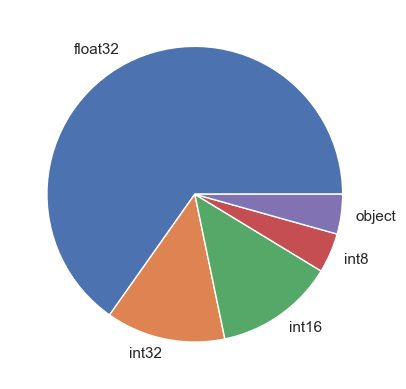

In [133]:
cc_bal.dtypes.value_counts().plot.pie()
plt.ylabel('')
plt.show()

In [134]:
M = recap_missing_values(cc_bal)
M

,Variable,Nombre de valeurs renseignées,Nombre de valeurs manquantes,Taux de remplissage (%)
0,SK_ID_PREV,3840312,0,100.000
1,SK_ID_CURR,3840312,0,100.000
2,MONTHS_BALANCE,3840312,0,100.000
3,AMT_BALANCE,3840312,0,100.000
4,AMT_CREDIT_LIMIT_ACTUAL,3840312,0,100.000
5,AMT_DRAWINGS_ATM_CURRENT,3090496,749816,80.475
6,AMT_DRAWINGS_CURRENT,3840312,0,100.000
7,AMT_DRAWINGS_OTHER_CURRENT,3090496,749816,80.475
8,AMT_DRAWINGS_POS_CURRENT,3090496,749816,80.475
9,AMT_INST_MIN_REGULARITY,3535076,305236,92.052


In [135]:
# Recherche de lignes doublons sur chaque variable

d = cc_bal.duplicated(keep='first').sum()
print(f'Nombre de lignes doublons : {d}')

Nombre de lignes doublons : 0


In [136]:
cc_bal['SK_ID_CURR'].nunique()

103558

In [137]:
comparaison_key(temp_app, cc_bal, 'SK_ID_CURR', 'SK_ID_CURR').head(5)

Nombre de clé de df1 absentes de df2 : 252691


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_Unemployed,ORGANIZATION_TYPE_University
0,100002,1.0,0,0,0,0,0,202500.0,406597.5,24700.5,...,0,0,0,0,0,0,0,0,0,0
1,100003,0.0,0,1,0,1,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0,0,0,0,0,0
2,100004,0.0,1,0,1,0,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0,0,0,0,0
4,100007,0.0,0,0,0,0,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0,0,0,0,0
5,100008,0.0,0,0,0,0,0,99000.0,490495.5,27517.5,...,0,0,0,0,0,0,0,0,0,0


252687 clients absents du dataframe credit_card_balance.

In [138]:
cc_bal = cc_bal[cc_bal['SK_ID_CURR'].isin(temp_app['SK_ID_CURR'])]
dim(cc_bal)

Le jeu de données contient 3840270 lignes et 23 colonnes.


In [139]:
cc_bal['SK_ID_PREV'].nunique()

104306

In [140]:
list_var_categ = cc_bal.select_dtypes('object').columns.tolist()
list_var_categ

['NAME_CONTRACT_STATUS']

In [141]:
# Number of unique classes in each object column
cc_bal[list_var_categ].nunique()

NAME_CONTRACT_STATUS    7
dtype: int64

In [142]:
cc_bal['NAME_CONTRACT_STATUS'].unique().tolist()

['Active',
 'Completed',
 'Demand',
 'Signed',
 'Sent proposal',
 'Refused',
 'Approved']

In [143]:
col_to_del = compute_mode_percentage(cc_bal, cc_bal.columns, threshold=0.99)

                        Column     Mode  Mode_pct
0                   SK_ID_PREV  1000096  0.000025
1                   SK_ID_CURR   186401  0.000050
2               MONTHS_BALANCE       -4  0.026590
10         AMT_PAYMENT_CURRENT      0.0  0.127105
19   CNT_INSTALMENT_MATURE_CUM      0.0  0.155993
4      AMT_CREDIT_LIMIT_ACTUAL        0  0.196294
9      AMT_INST_MIN_REGULARITY      0.0  0.545633
14        AMT_TOTAL_RECEIVABLE      0.0  0.550378
13               AMT_RECIVABLE      0.0  0.550423
3                  AMT_BALANCE      0.0  0.561517
11   AMT_PAYMENT_TOTAL_CURRENT      0.0  0.565632
12    AMT_RECEIVABLE_PRINCIPAL      0.0  0.597907
6         AMT_DRAWINGS_CURRENT      0.0  0.839368
16        CNT_DRAWINGS_CURRENT        0  0.841063
15    CNT_DRAWINGS_ATM_CURRENT      0.0  0.862553
5     AMT_DRAWINGS_ATM_CURRENT      0.0  0.862553
18    CNT_DRAWINGS_POS_CURRENT      0.0  0.914285
8     AMT_DRAWINGS_POS_CURRENT      0.0  0.914285
21                      SK_DPD        0  0.960067


In [144]:
percentile_report(cc_bal, cc_bal.select_dtypes(include='number').columns)

,0%,1.0%,5.0%,10.0%,25.0%,50.0%,75.0%,90.0%,95.0%,99.0%,100%
SK_ID_PREV,1.000018e+06,1.010017e+06,1082648.0,1176859.0,1.434349e+06,1.897122e+06,2.369288e+06,2.652010e+06,2.748797e+06,2.825323e+06,2843496.000
SK_ID_CURR,1.000060e+05,1.035691e+05,118195.0,135912.0,1.895170e+05,2.783910e+05,3.675830e+05,4.214920e+05,4.381610e+05,4.527490e+05,456250.000
MONTHS_BALANCE,-9.600000e+01,-9.300000e+01,-84.0,-76.0,-5.500000e+01,-2.800000e+01,-1.100000e+01,-5.000000e+00,-3.000000e+00,-1.000000e+00,-1.000
AMT_BALANCE,-4.202502e+05,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,8.904793e+04,1.800165e+05,2.571830e+05,4.662956e+05,1505902.125
AMT_CREDIT_LIMIT_ACTUAL,0.000000e+00,0.000000e+00,0.0,0.0,4.500000e+04,1.125000e+05,1.800000e+05,4.275000e+05,4.500000e+05,7.650000e+05,1350000.000
AMT_DRAWINGS_ATM_CURRENT,-6.827310e+03,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,6.750000e+03,3.375000e+04,1.350000e+05,2115000.000
AMT_DRAWINGS_CURRENT,-6.211620e+03,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.125000e+04,4.500000e+04,1.575000e+05,2287098.250
AMT_DRAWINGS_OTHER_CURRENT,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1529847.000
AMT_DRAWINGS_POS_CURRENT,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.011600e+04,7.708061e+04,2239274.250
AMT_INST_MIN_REGULARITY,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,6.634215e+03,9.000000e+03,1.350000e+04,2.331281e+04,202882.000


<br>

---

### <span style='background :#e3e33d' > 8.2 Script </span>

In [145]:
def credit_card_balance():

    cc_bal = pd.read_csv("./data/credit_card_balance.csv")

    # Remove the feature where mode % > 0.94
    col_to_del = compute_mode_percentage(cc_bal, cc_bal.columns, threshold=0.99, pr=False)
    cc_bal.drop(columns=col_to_del, inplace=True)

    cc_bal, cat_cols = one_hot_encoder(cc_bal, nan_as_category=False)


    # Feature engineering
    # Amount used from limit
    cc_bal['LIMIT_USE'] = cc_bal['AMT_BALANCE'] / (cc_bal['AMT_CREDIT_LIMIT_ACTUAL'] + 1)

    # How much drawing of limit
    cc_bal['DRAWING_LIMIT_RATIO'] = cc_bal['AMT_DRAWINGS_ATM_CURRENT'] / (cc_bal['AMT_CREDIT_LIMIT_ACTUAL'] + 1)

    # Current payment / Min payment
    cc_bal['PAYMENT_DIV_MIN'] = cc_bal['AMT_PAYMENT_CURRENT'] / (cc_bal['AMT_INST_MIN_REGULARITY'] + 1)

    # Late payment <-- 'CARD_IS_DPD'
    cc_bal['LATE_PAYMENT'] = cc_bal['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    cc_bal['CARD_IS_DPD_OVER_120'] = cc_bal['SK_DPD'].apply(lambda x: 1 if x >= 120 else 0)

    cc_bal['DPD_DEF_RATIO'] = cc_bal['SK_DPD_DEF'] / (cc_bal['SK_DPD'] + 1)


    # After the feature engineering, check for inf
    check_for_inf(cc_bal)

    # credit_card_balance numeric features
    num_aggregations = {
        'SK_ID_PREV': ['nunique'],
        'SK_ID_CURR': ['size'],
        'MONTHS_BALANCE': ['max', 'mean'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean'],
        'LIMIT_USE': ['max', 'mean', 'sum', 'var'],
        'DRAWING_LIMIT_RATIO': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIV_MIN': ['max', 'mean', 'sum', 'var'],
        'LATE_PAYMENT': ['mean'],
        'CARD_IS_DPD_OVER_120': ['mean'],
        'DPD_DEF_RATIO': ['max', 'mean']
    }

    # credit_card_balance other numeric features
    col_amt_cnt = [col for col in cc_bal.columns if (col.startswith('AMT_') or col.startswith('CNT_'))]

    for col in col_amt_cnt:
        num_aggregations[col] = ['min', 'max', 'mean', 'sum', 'var']

    # credit_card_balance categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    # Aggregation
    cc_bal_agg = cc_bal.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    cc_bal_agg = flatten_multi_index(cc_bal_agg, prefix='CC_')

    del cc_bal
    gc.collect()

    check_full_nan(cc_bal_agg)

    # Remove the feature where mode % = 1
    col_to_del = compute_mode_percentage(cc_bal_agg, cc_bal_agg.columns, threshold=1, pr=False)
    cc_bal_agg.drop(columns=col_to_del, inplace=True)

    print('"Credit Card Balance" final shape:', cc_bal_agg.shape)

    return cc_bal_agg

In [146]:
temp_credit_card = credit_card_balance()
temp_credit_card.head()

Liste des features à supprimer :
['AMT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT']
Nombre de valeurs infinies: 0
Liste de features full of nan:
[]
Liste des features à supprimer :
[]
"Credit Card Balance" final shape: (103558, 107)


,SK_ID_CURR,CC_SK_ID_PREV_NUNIQUE,CC_SK_ID_CURR_SIZE,CC_MONTHS_BALANCE_MAX,CC_MONTHS_BALANCE_MEAN,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_LIMIT_USE_MAX,...,CC_CNT_INSTALMENT_MATURE_CUM_MEAN,CC_CNT_INSTALMENT_MATURE_CUM_SUM,CC_CNT_INSTALMENT_MATURE_CUM_VAR,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Signed_MEAN
0,100006,1,6,-1,-3.5,0,0.000000,0,0.000000,0.000000,...,0.000000,0.0,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,100011,1,74,-2,-38.5,0,0.000000,0,0.000000,1.049994,...,25.767123,1881.0,105.847793,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0
2,100013,1,96,-1,-48.5,1,0.010417,1,0.010417,1.024884,...,18.719101,1666.0,34.249745,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0
3,100021,1,17,-2,-10.0,0,0.000000,0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.411765,0.0,0.588235,0.0,0.0,0.0,0.0
4,100023,1,8,-4,-7.5,0,0.000000,0,0.000000,0.000000,...,0.000000,0.0,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0


In [147]:
dim(temp_credit_card)

Le jeu de données contient 103558 lignes et 107 colonnes.


<br>

---

##  <span style='background :#96e773' > 9. Fusion des jeux de données </span>

In [148]:
print('--=> df:', temp_app.shape)

df_final = temp_app.merge(temp_bureau, how='left', on='SK_ID_CURR')
print('--=> df after merge with bureau:', df_final.shape)

df_final = df_final.merge(temp_previous, how='left', on='SK_ID_CURR')
print('--=> df after merge with previous application:', df_final.shape)

df_final = df_final.merge(temp_pos, how='left', on='SK_ID_CURR')
print('--=> df after merge with pos cash :', df_final.shape)

df_final = df_final.merge(temp_ins, how='left', on='SK_ID_CURR')
print('--=> df after merge with installments:', df_final.shape)

df_final = df_final.merge(temp_credit_card, how='left', on='SK_ID_CURR')
print('--=> df after merge with credit card:', df_final.shape)

--=> df: (356248, 196)
--=> df after merge with bureau: (356248, 349)
--=> df after merge with previous application: (356248, 621)
--=> df after merge with pos cash : (356248, 645)
--=> df after merge with installments: (356248, 680)
--=> df after merge with credit card: (356248, 786)


In [149]:
df_final.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_CNT_INSTALMENT_MATURE_CUM_MEAN,CC_CNT_INSTALMENT_MATURE_CUM_SUM,CC_CNT_INSTALMENT_MATURE_CUM_VAR,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Signed_MEAN
0,100002,1.0,0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0.0,0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0.0,1,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0.0,0,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0.0,0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [150]:
missing_values(df_final)

Le jeu de données contient 68300493 valeurs manquantes (24.392%).


On liste les variables contenant 'SK_ID' afin de pouvoir remplacer les nan par 0. En effet, les clients présents dans application_train ou application_test et absents des jeux de données additionnels auront des valeurs manquantes pour ces variables.

In [151]:
col_SK_ID = [col for col in df_final.columns if 'SK_ID' in col]
col_SK_ID.remove('SK_ID_CURR')
col_SK_ID

['BURO_SK_ID_BUREAU_SIZE',
 'ACTIVE_SK_ID_BUREAU_SIZE',
 'CLOSED_SK_ID_BUREAU_SIZE',
 'PREV_SK_ID_PREV_NUNIQUE',
 'APPROVED_SK_ID_PREV_NUNIQUE',
 'REFUSED_SK_ID_PREV_NUNIQUE',
 'POS_SK_ID_PREV_NUNIQUE',
 'POS_SK_ID_CURR_SIZE',
 'INSTAL_SK_ID_PREV_NUNIQUE',
 'INSTAL_SK_ID_CURR_SIZE',
 'CC_SK_ID_PREV_NUNIQUE',
 'CC_SK_ID_CURR_SIZE']

In [152]:
df_final.loc[:, col_SK_ID] = df_final[col_SK_ID].replace(np.nan, 0)

On peut maintenant compter le nombre de clients sans aucune information additionnelle.

In [153]:
temp = df_final[df_final[col_SK_ID].sum(axis=1) == 0]
temp

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_CNT_INSTALMENT_MATURE_CUM_MEAN,CC_CNT_INSTALMENT_MATURE_CUM_SUM,CC_CNT_INSTALMENT_MATURE_CUM_VAR,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Signed_MEAN
20,100024,0.0,1,0,1,0,0,135000.0,427500.0,21375.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120,100140,0.0,1,1,0,1,0,157500.0,675000.0,33750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
203,100236,0.0,0,0,1,0,0,112500.0,312768.0,20353.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242,100282,1.0,1,1,1,0,0,73341.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
403,100467,0.0,0,1,0,1,0,81000.0,225000.0,13284.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355395,449942,NaN,1,1,0,0,0,315000.0,1350000.0,67500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
355424,450148,NaN,0,1,1,0,0,121500.0,135000.0,5791.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
355428,450180,NaN,0,1,0,1,0,135000.0,900000.0,48825.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
355603,451383,NaN,0,1,0,0,0,90000.0,278460.0,20947.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


2357 clients sans aucune information additionnelle venant des jeux de données bureau, previous application, etc.

In [154]:
temp['TARGET'].value_counts(normalize=True)

0.0    0.928539
1.0    0.071461
Name: TARGET, dtype: float64

La distribution de la target pour ces clients est similaire à celle des autres clients.

In [155]:
(temp.isnull().sum(axis=1) / temp.shape[1] * 100).min()

73.53689567430025

In [156]:
(temp.isnull().sum(axis=1) / temp.shape[1] * 100).max()

77.2264631043257

Le taux de valeurs manquantes oscille entre 73 et 77 % pour ces clients.

On calcule maintenant la distribution des valeurs manquantes par client.

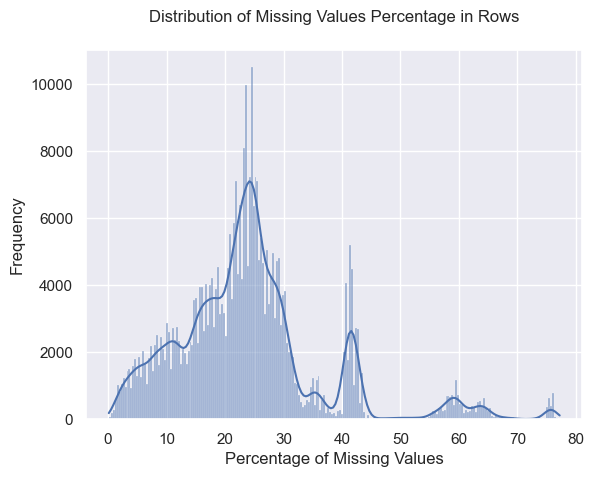

In [157]:
# Calculate the number of missing values for each row
missing_values_count = df_final.isna().sum(axis=1)

# Calculate the percentage of missing values
missing_values_percentage = (missing_values_count / df_final.shape[1]) * 100

# Set the style for the plot
sns.set(style='darkgrid')

# Create the distribution plot
sns.histplot(data=missing_values_percentage, kde=True)

# Set the title and labels for the plot
plt.title('Distribution of Missing Values Percentage in Rows')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Frequency')

# Display the plot
plt.show()

On crée une nouvelle variable qui indique le pourcentage de valeurs manquantes d'un client.

In [158]:
# Calculate the number of missing values for each row
missing_values_count = df_final.isna().sum(axis=1)

# Calculate the percentage of missing values
missing_values_percentage = (missing_values_count / df_final.shape[1]) * 100

# Add the percentage of missing values as a new feature to the DataFrame
df_final['missing_values_percentage'] = missing_values_percentage

In [159]:
M = recap_missing_values(df_final)
M.sort_values(by='Taux de remplissage (%)')

,Variable,Nombre de valeurs renseignées,Nombre de valeurs manquantes,Taux de remplissage (%)
294,ACTIVE_ENDDATE_DIF_MIN,1903,354345,0.534
296,ACTIVE_ENDDATE_DIF_MEAN,1903,354345,0.534
295,ACTIVE_ENDDATE_DIF_MAX,1903,354345,0.534
613,REFUSED_PREV_DOWN_PAYMENT_TO_CREDIT_MEAN,25306,330942,7.103
582,REFUSED_AMT_DOWN_PAYMENT_MIN,25306,330942,7.103
...,...,...,...,...
148,ORGANIZATION_TYPE_Government,356248,0,100.000
147,ORGANIZATION_TYPE_Emergency,356248,0,100.000
146,ORGANIZATION_TYPE_Electricity,356248,0,100.000
153,ORGANIZATION_TYPE_Industry: type 11,356248,0,100.000


On filtre et supprime les variables avec un taux de remplissage inférieur à 20 %.

In [160]:
var_20 = M[M['Taux de remplissage (%)'] < 20]['Variable'].tolist()
var_20

['ACTIVE_ENDDATE_DIF_MIN',
 'ACTIVE_ENDDATE_DIF_MAX',
 'ACTIVE_ENDDATE_DIF_MEAN',
 'CLOSED_AMT_ANNUITY_MAX',
 'CLOSED_AMT_ANNUITY_MEAN',
 'REFUSED_AMT_DOWN_PAYMENT_MIN',
 'REFUSED_AMT_DOWN_PAYMENT_MAX',
 'REFUSED_AMT_DOWN_PAYMENT_MEAN',
 'REFUSED_RATE_DOWN_PAYMENT_MIN',
 'REFUSED_RATE_DOWN_PAYMENT_MAX',
 'REFUSED_RATE_DOWN_PAYMENT_MEAN',
 'REFUSED_PREV_APP_CREDIT_PERC_VAR',
 'REFUSED_PREV_DOWN_PAYMENT_TO_CREDIT_MEAN']

In [161]:
df_final.drop(columns=var_20, inplace=True)

Pour finir, on corrige les noms des variables contenant des caractères spéciaux.

In [162]:
import re

df_final = df_final.rename(columns=lambda x: re.sub('\W', '_', x))

On peut maintenant séparer les jeux d'entrainement et de test.

In [163]:
train = df_final[df_final['TARGET'].notna()]
test = df_final[df_final['TARGET'].isna()]
test = test.drop(columns='TARGET')

In [164]:
train.shape

(307504, 774)

In [165]:
test.shape

(48744, 773)

In [166]:
train.to_csv('train_after_merging.csv', index=False)
test.to_csv('test_after_merging.csv', index=False)